In [36]:

from cmath import inf
from mlinsights.plotting import pipeline2str
from mlinsights.plotting import pipeline2dot

#load pickle evaluated pipelines

from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
import dill as pickle
import sys
import pandas as pd
from tpot import TPOTClassifier
import deap
from deap import creator
sys.path.append('/Users/matsumoton/Git/digen')
from digen import Benchmark

import pydot 
from IPython.display import Image, display

import networkx as nx
import random
import math

class TrieNode:
 
    def __init__(self, primitive):
        self.primitive = primitive
        self.path = 'root'
        self.traverse_count = 0
        self.total_cv_score = []
        self.generation = []
        self.children = {}
        self.parents = []
        self.depth = 0
        self.max_score = -inf
        self.min_score = inf
        self.diversity_score = 0
 
class PipelineTrie(object):
 
    def __init__(self):
        self.root = TrieNode("")
        
    def insert(self, pipeline_str,pipeline_data,pset):

        def prim_to_list(prim, args):
            if isinstance(prim, deap.gp.Terminal):
                return None
            return [prim.name] + args
        def remove_none(obj):
            if isinstance(obj, (list, tuple, set)):
                return type(obj)(remove_none(x) for x in obj if x is not None)
            elif isinstance(obj, dict):
                return type(obj)((remove_none(k), remove_none(v))
                for k, v in obj.items() if k is not None and v is not None)
            else:
                return obj

        pipeline = creator.Individual.from_string(pipeline_str, pset)

        #convert pipeline into a list and change all hyperparameters to None
        tree = []
        stack = []
        for node in pipeline:
            stack.append((node, []))
            while len(stack[-1][1]) == stack[-1][0].arity:
                prim, args = stack.pop()
                tree = prim_to_list(prim, args)
                if len(stack) == 0:
                    break  # If stack is empty, all nodes should have been seen
                
                stack[-1][1].append(tree)
        
        #remove all Nones
        tree = remove_none(tree)
        
        #dfs through the tree and integrate into trie
        stack = []
        stack.append(tree)
        trie_stack = [self.root]

        while stack:
            s = stack.pop()
            node = trie_stack.pop()
            cur_depth = node.depth+1
            
            if (s[0]) not in node.children:
                node.children[(s[0])] = TrieNode(s[0])
                node.children[(s[0])].parents = np.append(node.parents,node)
                #add a value to the root diversity metric
                #self.root.diversity_score =  self.root.diversity_score + 1/cur_depth**2
                temp_depth = 1
                for tempnode in node.parents:
                    tempnode.diversity_score =  tempnode.diversity_score + 1/temp_depth**2
                    temp_depth = temp_depth + 1
            node.children[(s[0])].traverse_count = node.children[(s[0])].traverse_count + 1
            node.children[(s[0])].total_cv_score.append(pipeline_data["internal_cv_score"])
            node.children[(s[0])].generation.append(pipeline_data["generation"])
            node.children[(s[0])].depth = cur_depth
            if not math.isnan(pipeline_data["internal_cv_score"]) and not math.isinf(pipeline_data["internal_cv_score"]):
                node.children[(s[0])].min_score = min(node.children[(s[0])].min_score,pipeline_data["internal_cv_score"])
                node.children[(s[0])].max_score = max(node.children[(s[0])].max_score,pipeline_data["internal_cv_score"])
                self.root.min_score = min(self.root.min_score,pipeline_data["internal_cv_score"])
                self.root.max_score = max(self.root.max_score,pipeline_data["internal_cv_score"])
            if node.path != 'root':
                node.children[(s[0])].path = node.path + '-' + s[0]
            else:
                node.children[(s[0])].path = s[0]
            if len(s[1:]) > 0:
                stack.extend(s[1:])
                for i in range(len(s[1:])):
                    trie_stack.append(node.children[(s[0])])
                    

                
    def display(self,filename, depth=100):
        import networkx as nx
        from pyvis.network import Network
        import matplotlib as mpl

        def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
            c1=np.array(mpl.colors.to_rgb(c1))
            c2=np.array(mpl.colors.to_rgb(c2))
            return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

        c1='red' #blue
        c2='green' #green

        graph = pydot.Dot(graph_type='graph') 
        stack = [self.root]
        parent_stack = []

        max_height = depth
        while stack:
            s = stack.pop()
            if s.depth >= max_height:
                continue
            for k in s.children.keys():
                stack.append(s.children[k])
                temp =  [v for v in s.total_cv_score if not math.isnan(v) and not math.isinf(v)]
                if len(temp) :
                    parentnodeaccuracy =(sum(temp)/len(temp))
                    if parentnodeaccuracy > self.root.max_score:
                        parentnodeaccuracy = self.root.max_score
                    parentnodecolor = colorFader(c1,c2,(parentnodeaccuracy-self.root.min_score)/(self.root.max_score-self.root.min_score))
                else:
                    parentnodeaccuracy = 'NA'
                    parentnodecolor = "#666666"
                    
                temp =  [v for v in s.children[k].total_cv_score if not math.isnan(v) and not math.isinf(v)]
                if len(temp) :
                    childaccuracy = (sum(temp)/len(temp))
                    #floating point 0.00...01 issue
                    if childaccuracy > self.root.max_score:
                        childaccuracy = self.root.max_score
                    childcolor = colorFader(c1,c2,(childaccuracy-self.root.min_score)/(self.root.max_score-self.root.min_score))
                    
                else:
                    childaccuracy = 'NA'
                    childcolor = "#666666"
                
                graph.add_node(pydot.Node(s.path,label=s.primitive+'\n'+str(parentnodeaccuracy),color=parentnodecolor,size=10*(math.tanh(-s.depth+4)+2)))
                graph.add_node(pydot.Node(s.children[k].path,label=s.children[k].primitive+'\n'+str(childaccuracy),color=childcolor,size=10*(math.tanh(-s.children[k].depth+4)+2)))
                
                edge = pydot.Edge(s.path, s.children[k].path,weight=1,color='#515ba3',value=math.log(s.children[k].traverse_count))
                graph.add_edge(edge)



        G = nx.nx_pydot.from_pydot(graph)
        nt = Network(height='100%', width='100%', bgcolor='#333333', font_color='white')
        nt.from_nx(G)
        nt.show(filename+'.html')
 
    

from sklearn.utils import shuffle
from os import makedirs


def extract_labels(df, labelname):
    y = df[labelname].copy(deep=True)
    x = df.drop(labelname, axis=1)
    x, y = shuffle(x, y)
    x = x.to_numpy()
    y = y.to_numpy()
    return x, y

benchmark=Benchmark()
directoryevs = ["baseline_final","lexicase_final","dynamic_final","lexicase_dynamic_final"]
#directoryevs = ["lexicase_final"]
result = {}
diversity_scores= {}
#for j in [2,4,7,14,23,24,25,27,28,30,32,35,40]:
for j in [4,7,14,23,24,25,27,28,30,32,35,40]:
    print(j)
    diversity_scores[j] = {}
    dataset=benchmark.load_dataset('digen'+str(j))

    X, Y = extract_labels(dataset, "target")
    ev = []

    tpot = TPOTClassifier(verbosity=2, population_size=1, generations=1)
    tpot.fit(X, Y)

    for directoryev in directoryevs:
        temp_ev = []
        #pipeline_trie = PipelineTrie()
        diversity_scores[j][directoryev] = []
        for i in range(40):
            pipeline_trie = PipelineTrie()
            with open(f"C:/Users/matsumoton/Box/tpot_benchmark_data/results_pop40_gen20_{directoryev}/pipelines/digen{j}_run_{i}_evaluated_individuals.pkl", 'rb') as file:
                unpickler = pickle.Unpickler(file)
                result = unpickler.load()
                for k , v in result.items():
                    #print(k)
                    pipeline_trie.insert(k,v,tpot._pset)
            #pipeline_trie.display(f"{directoryev}_digen{j}_run{i}_ds_{pipeline_trie.root.diversity_score}")
            #if i in [5]:
                #pipeline_trie.display(f"{directoryev}_digen{j}_run{i}_ds_{pipeline_trie.root.diversity_score}")
                
            print(str(j) + ' ' +directoryev+' '+str(i) + ' ' + str([pipeline_trie.root.diversity_score,pipeline_trie.root.max_score]))
            diversity_scores[j][directoryev].append([pipeline_trie.root.diversity_score,pipeline_trie.root.max_score])
            break
    break

        
    
        
    


4
                                                                  
Generation 1 - Current best internal CV score: 0.477
                                                                          
Best pipeline: BernoulliNB(input_matrix, alpha=100.0, fit_prior=False)
4 baseline_final 0 [408.0, 0.9775914634146343]
4 lexicase_final 0 [324.0, 0.99875]
4 dynamic_final 0 [265.0, 0.9987179487179487]
4 lexicase_dynamic_final 0 [127.0, 0.9987179487179487]


In [20]:
diversity_scores


{4: {'baseline_final': [[70.62088577097552, 0.9775914634146343]],
  'lexicase_final': [[56.68611111111142, 0.99875]],
  'dynamic_final': [[54.30305555555577, 0.9987179487179487]],
  'lexicase_dynamic_final': [[36.86805555555563, 0.9987179487179487]]}}

In [9]:
#diversity_scores
with open(f"diversity_scores.pkl", 'wb') as outp:
            pickle.dump(diversity_scores, outp, -1)

In [5]:

            
directoryevs = ["baseline_final","lexicase_final","dynamic_final","lexicase_dynamic_final"]
            
with open(f"diversity_scores.pkl", 'rb') as outp:
    diversity_scores = pickle.load( outp)

2


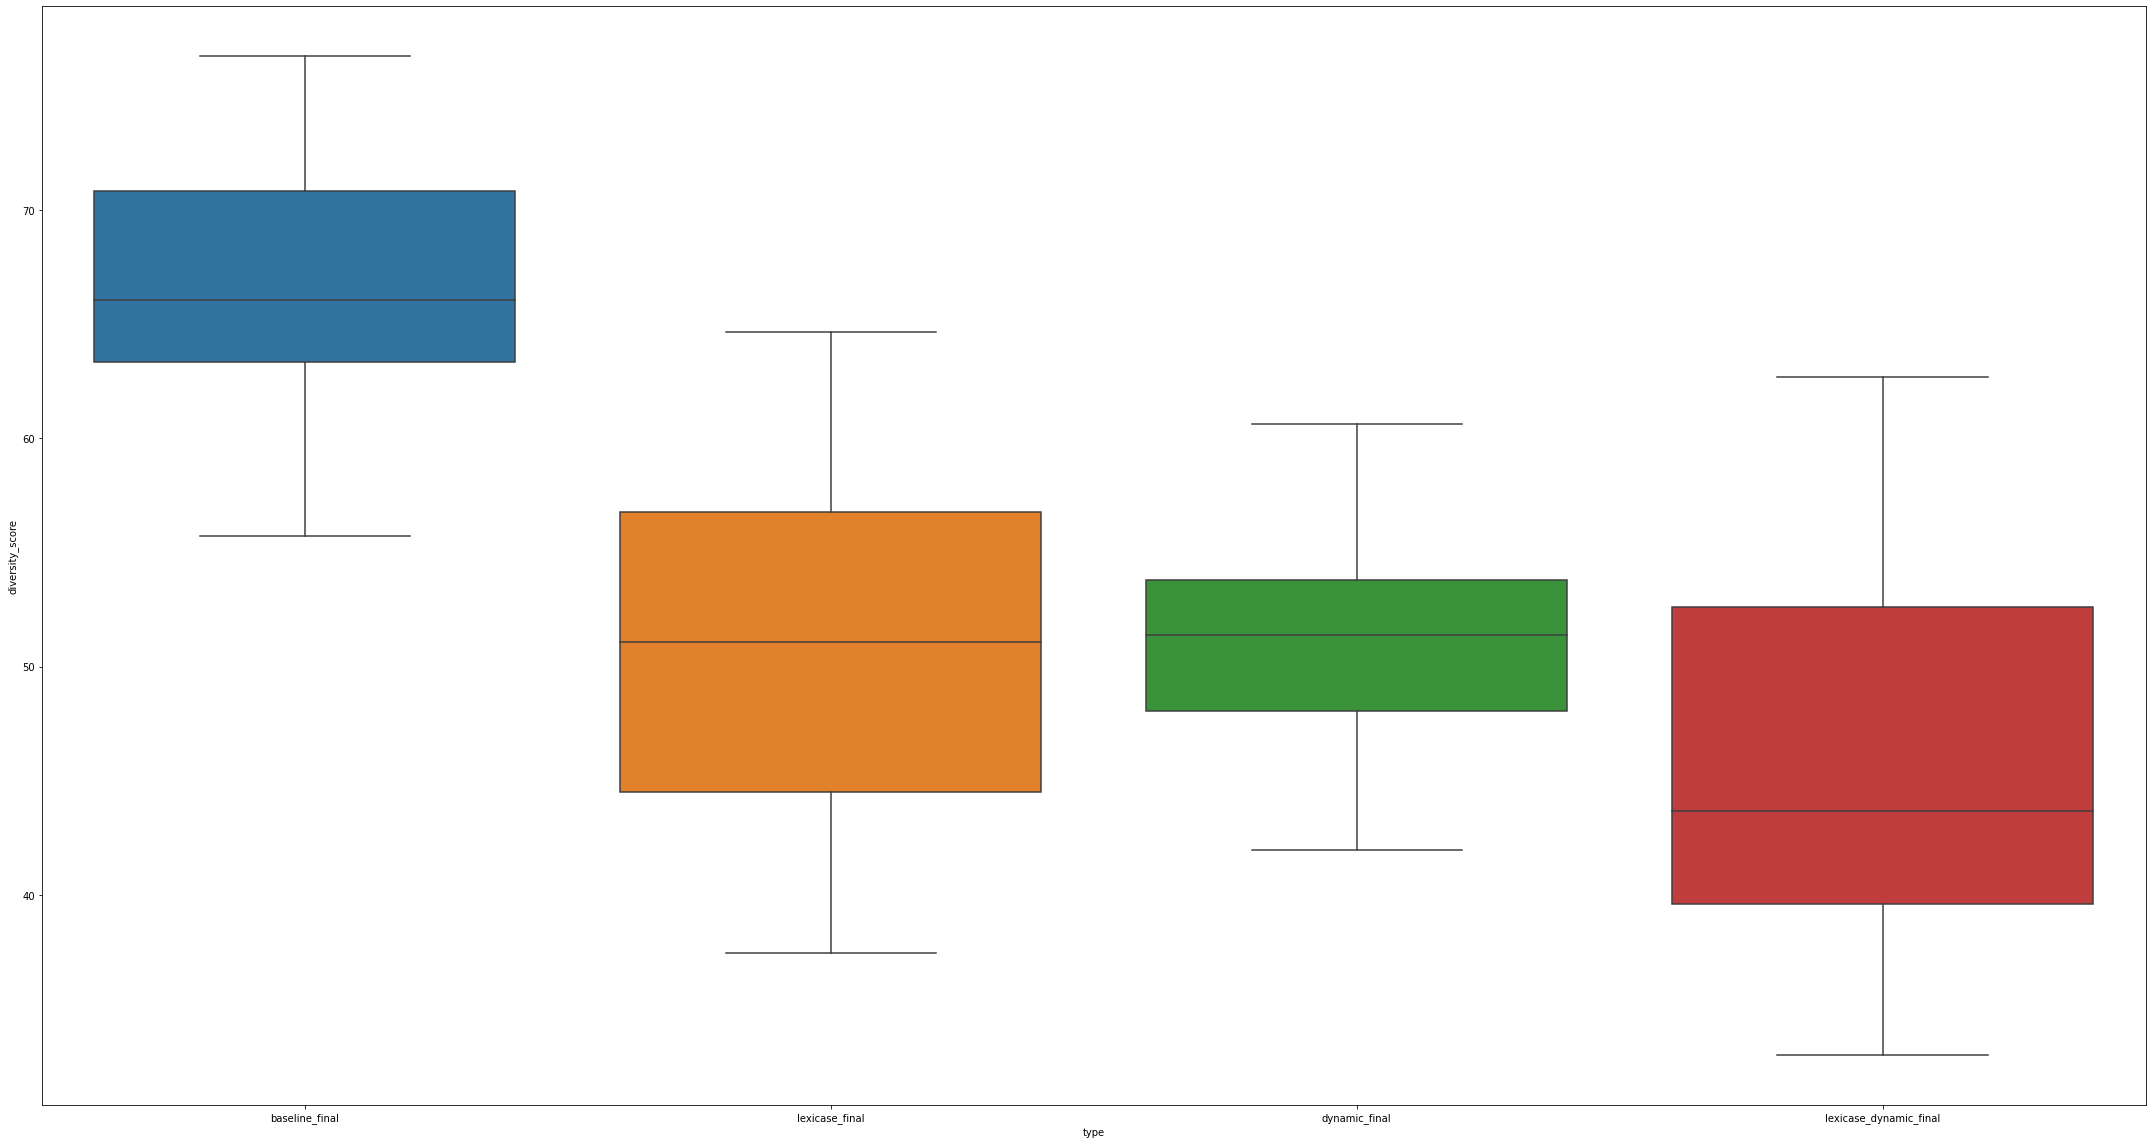

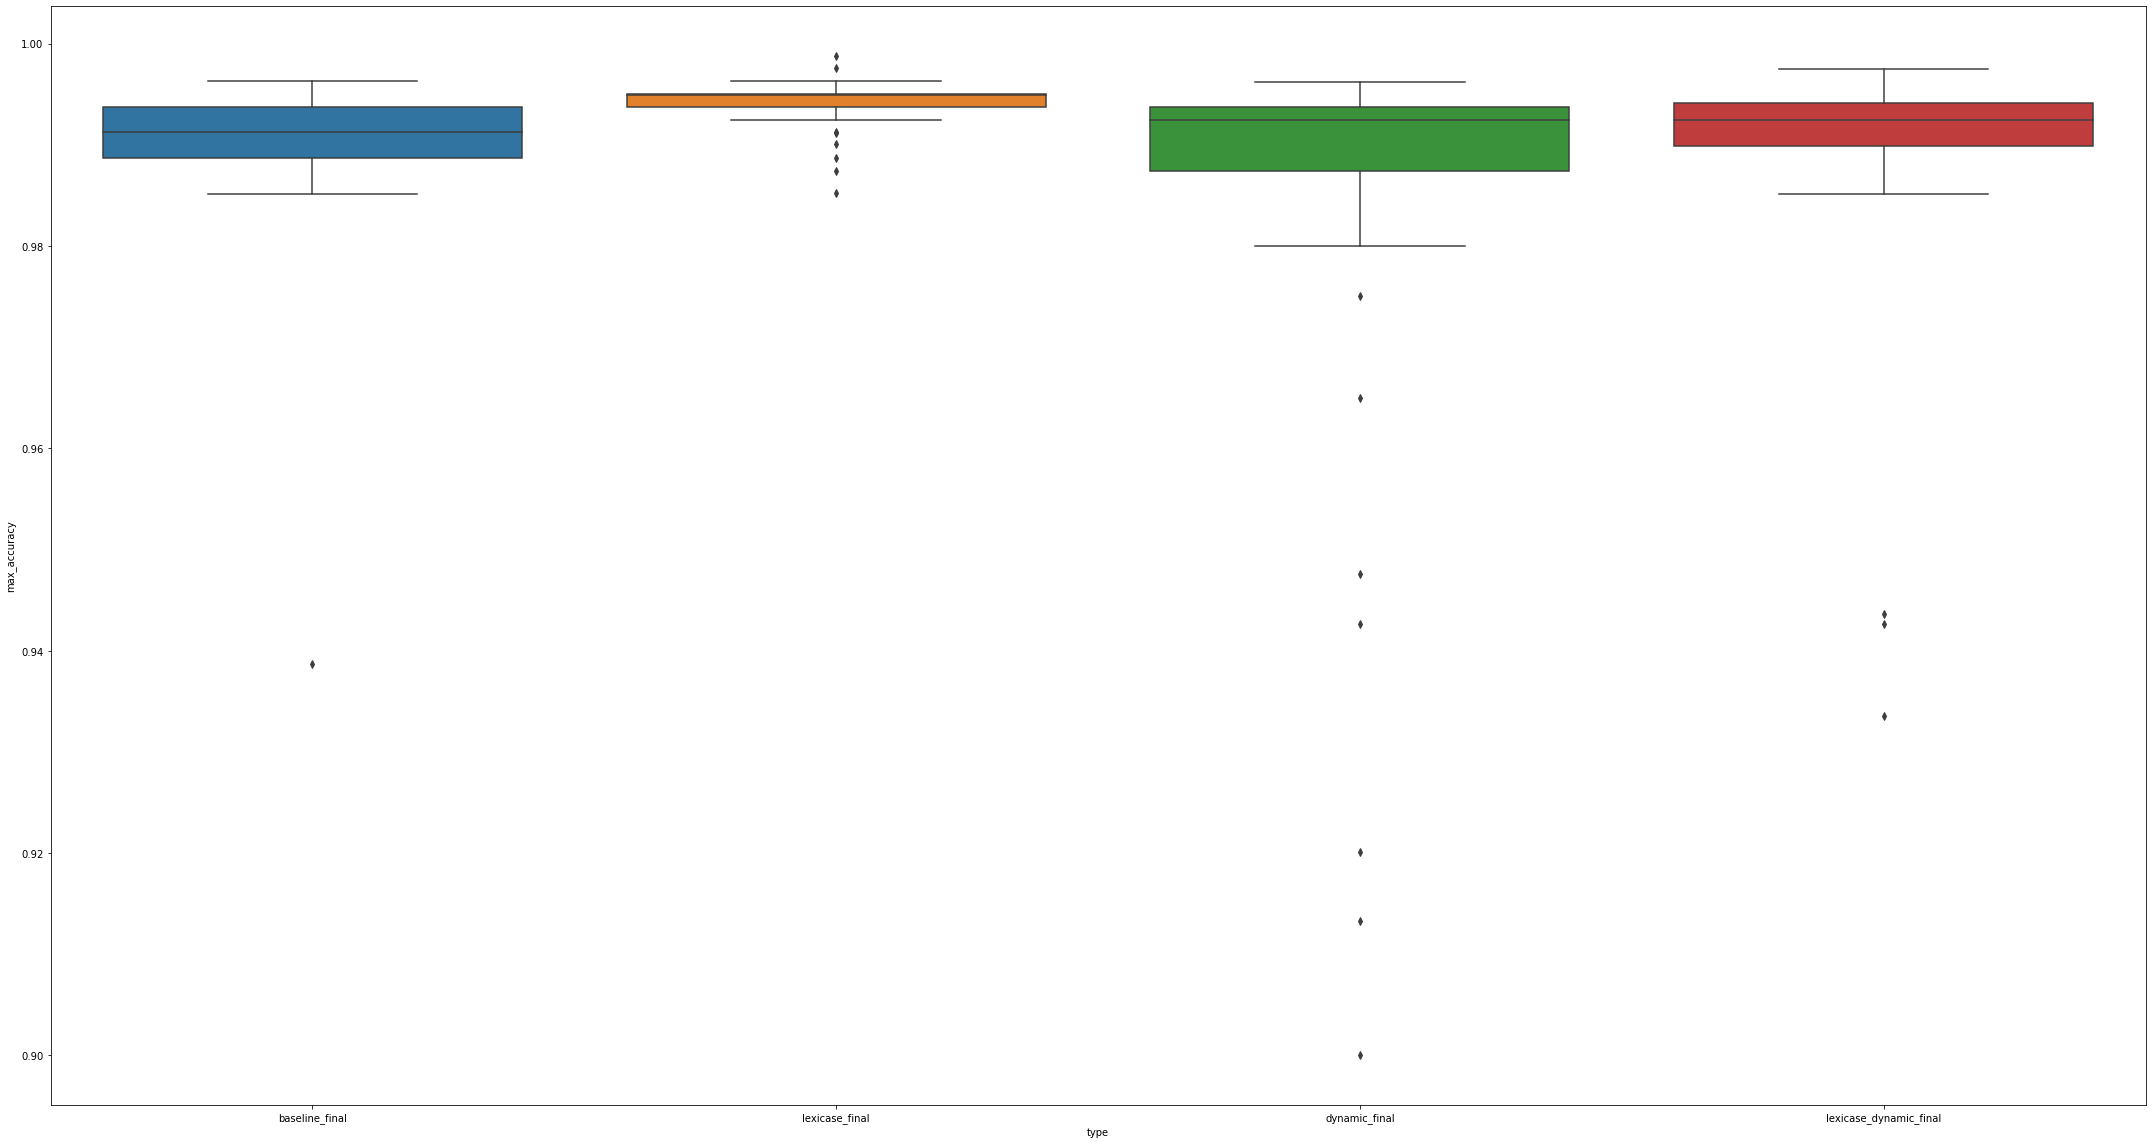

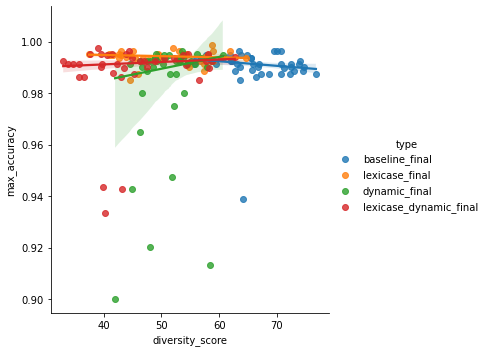

4


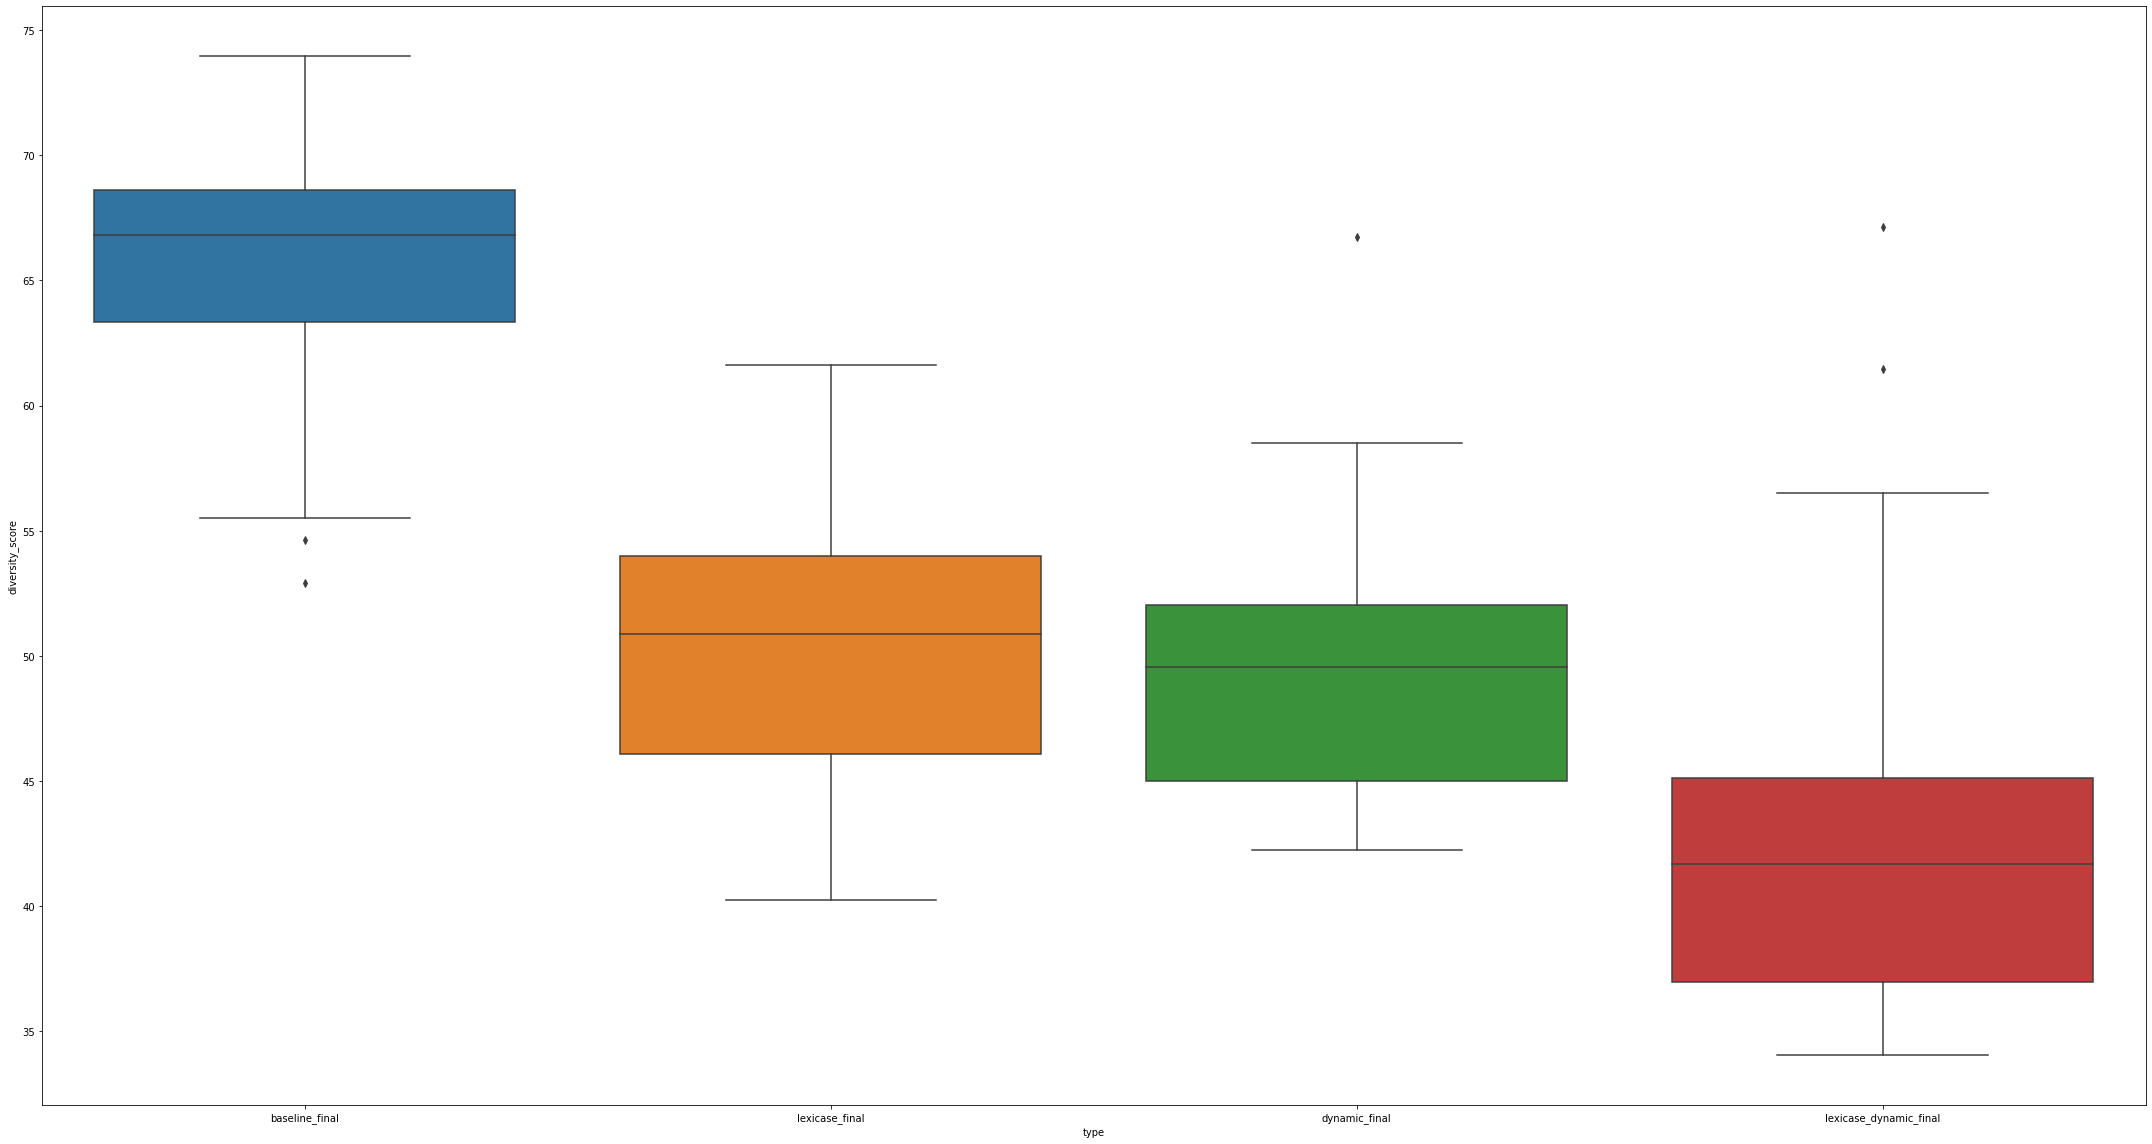

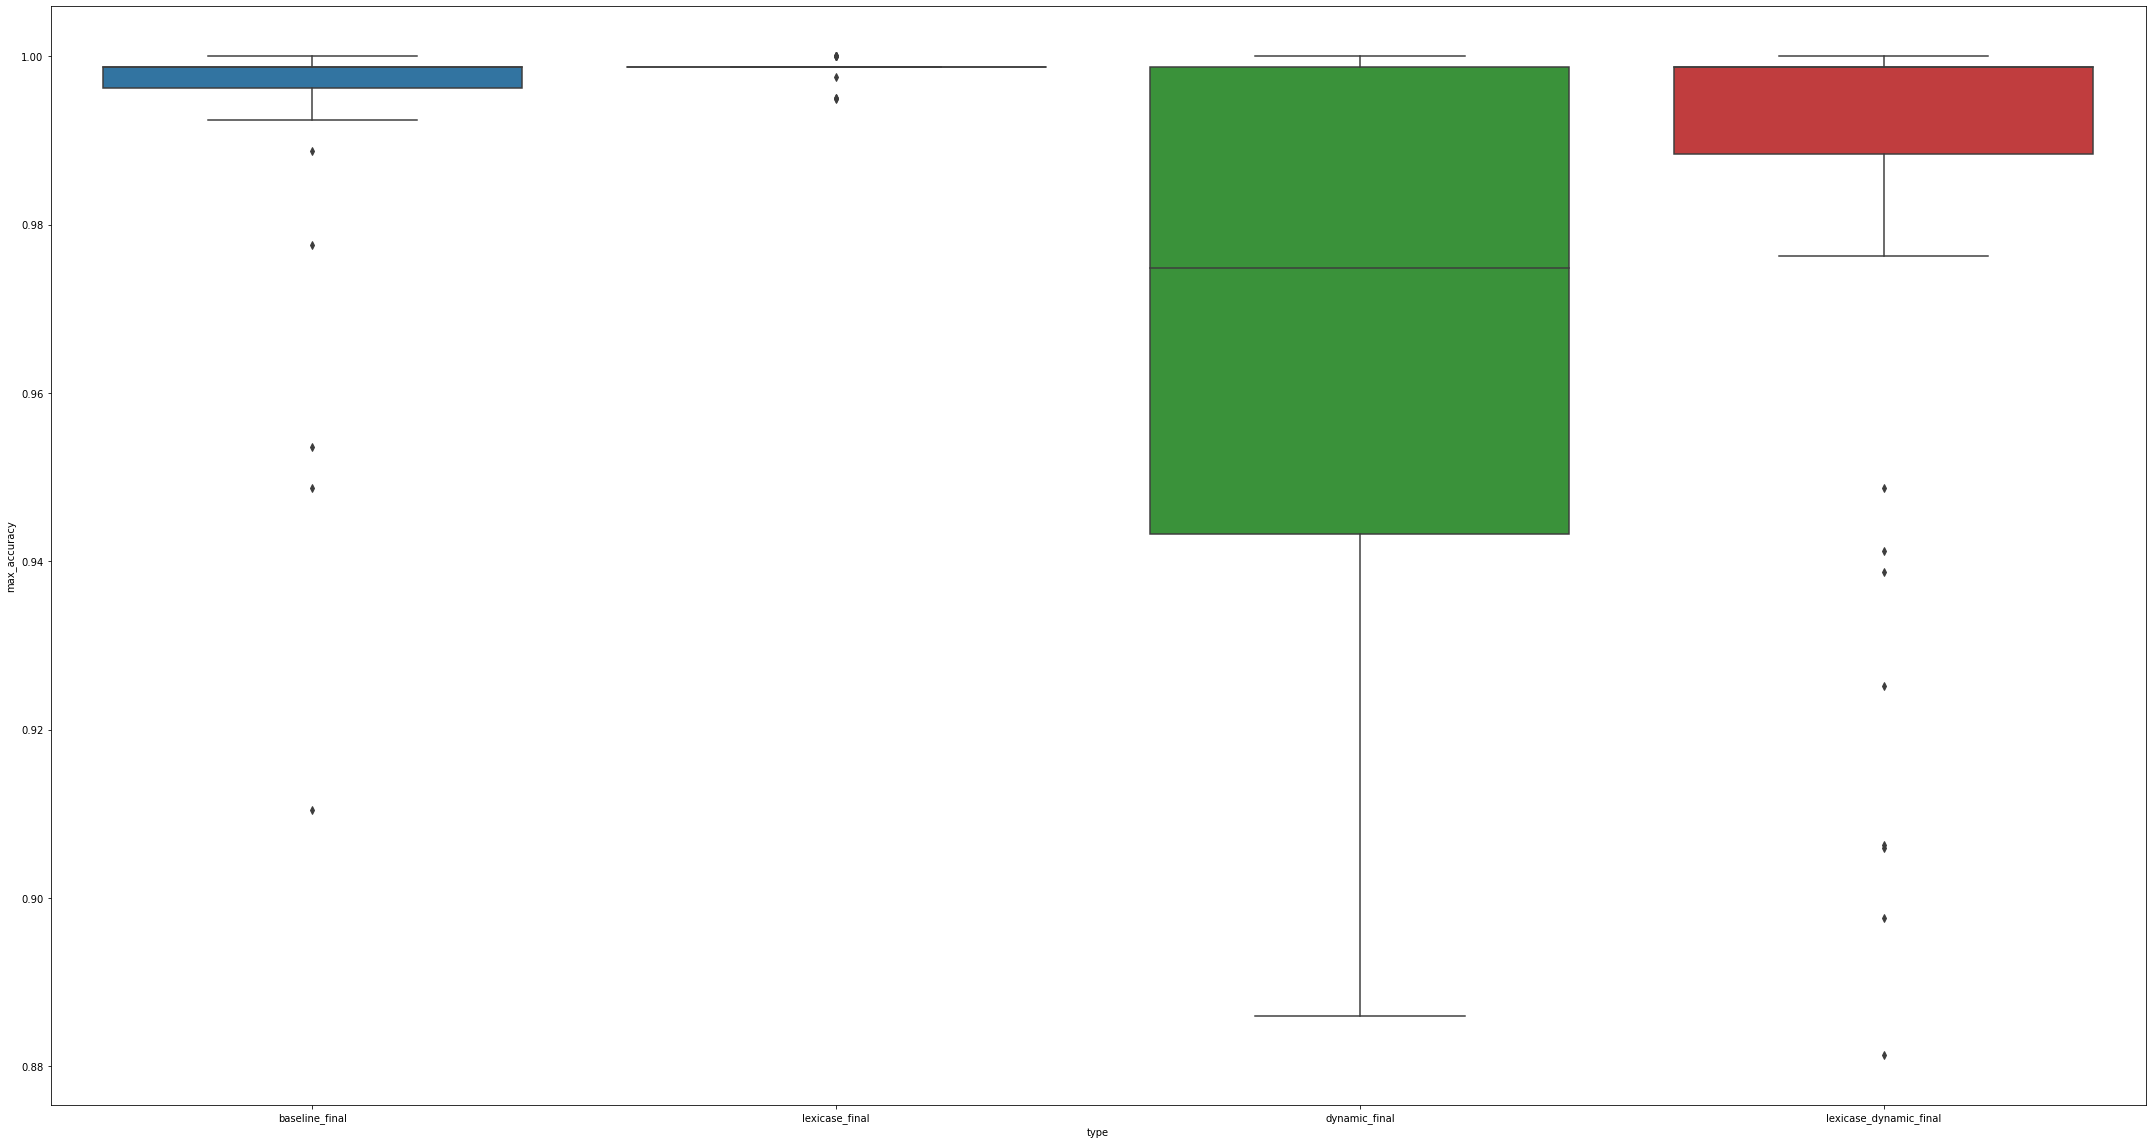

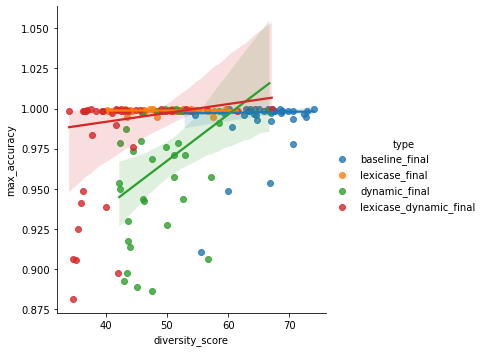

7


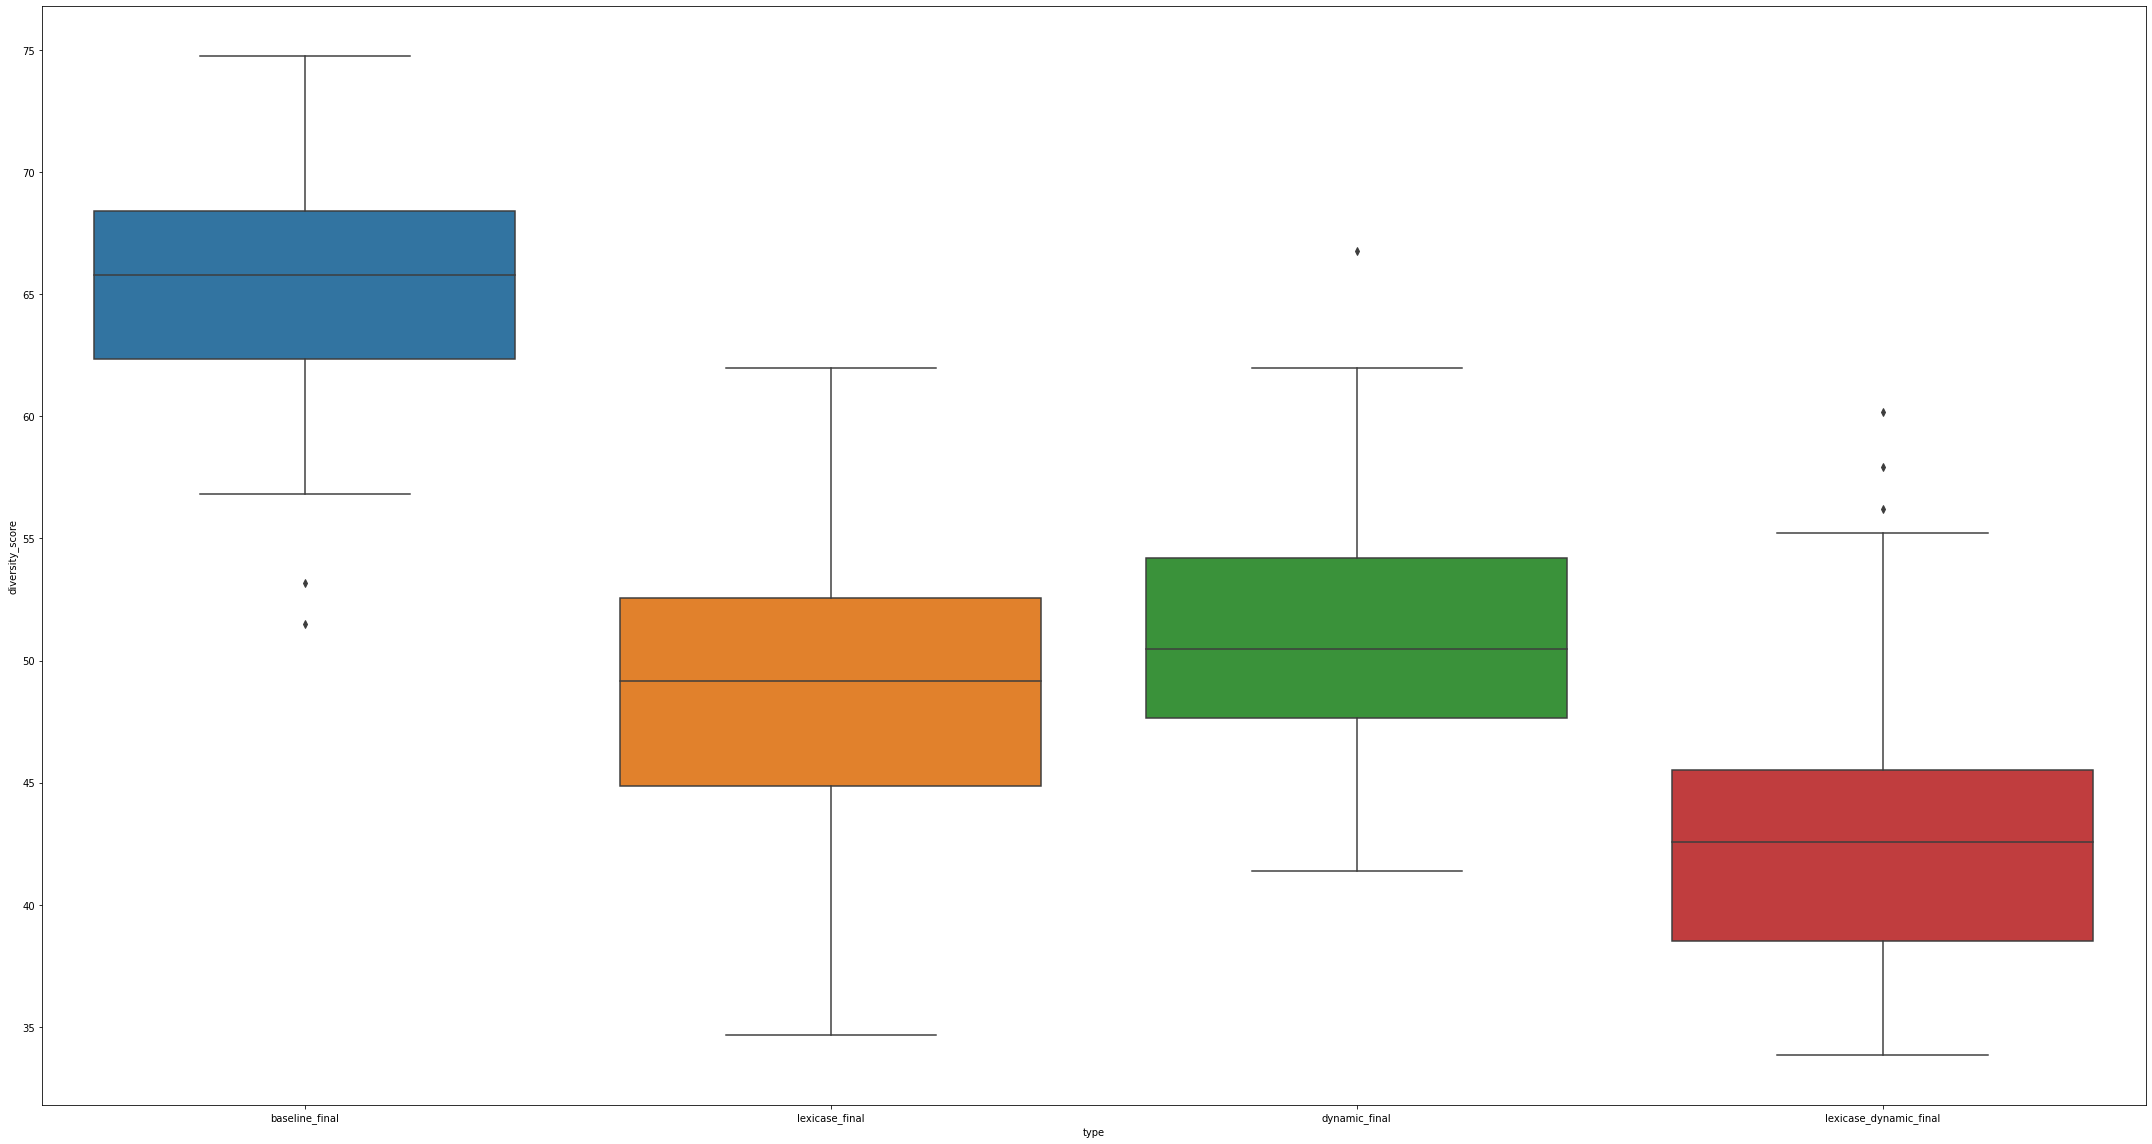

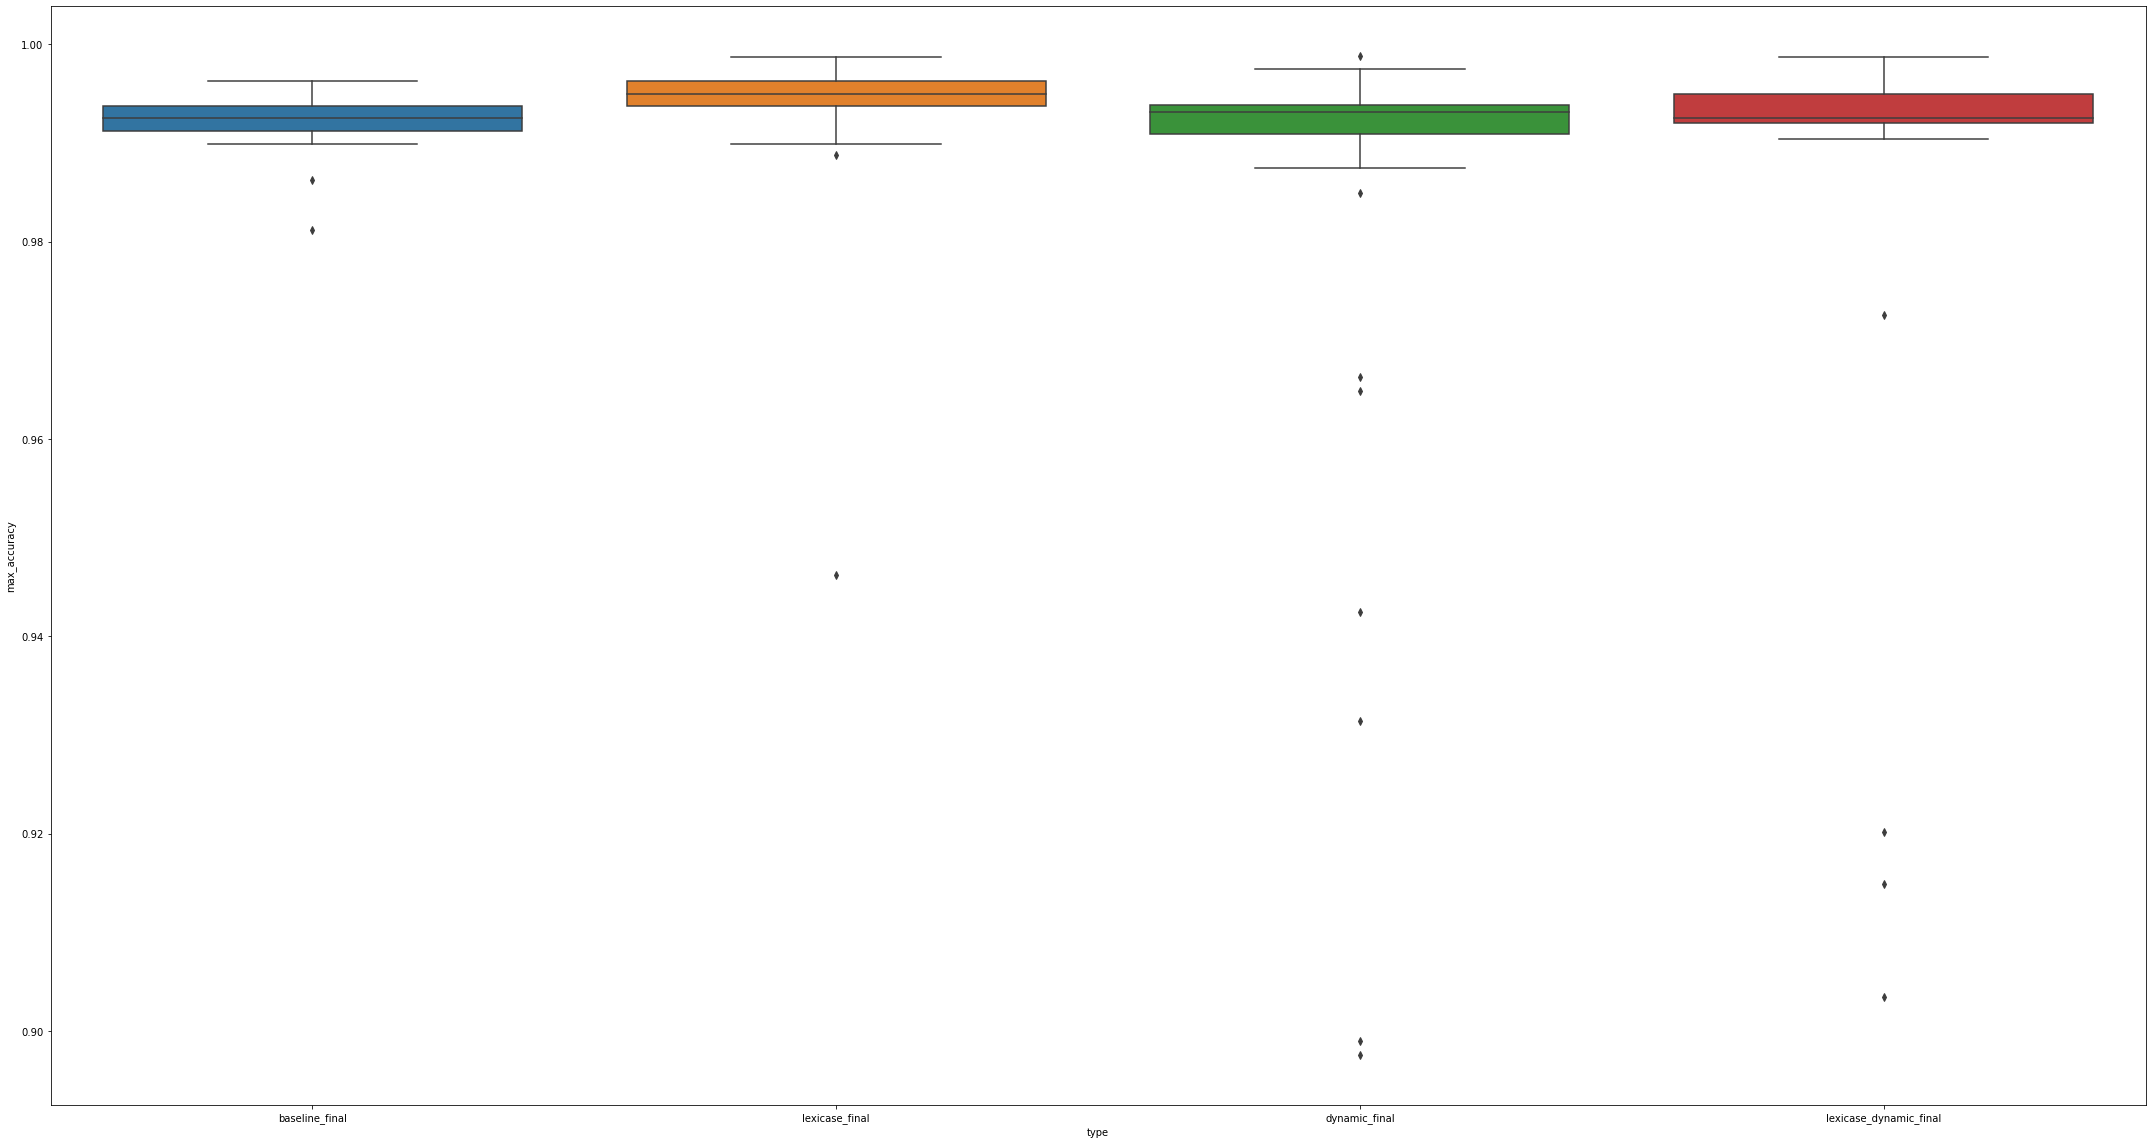

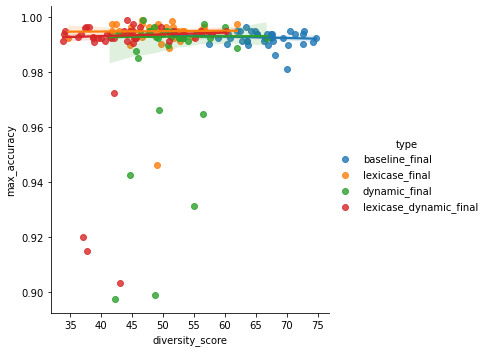

14


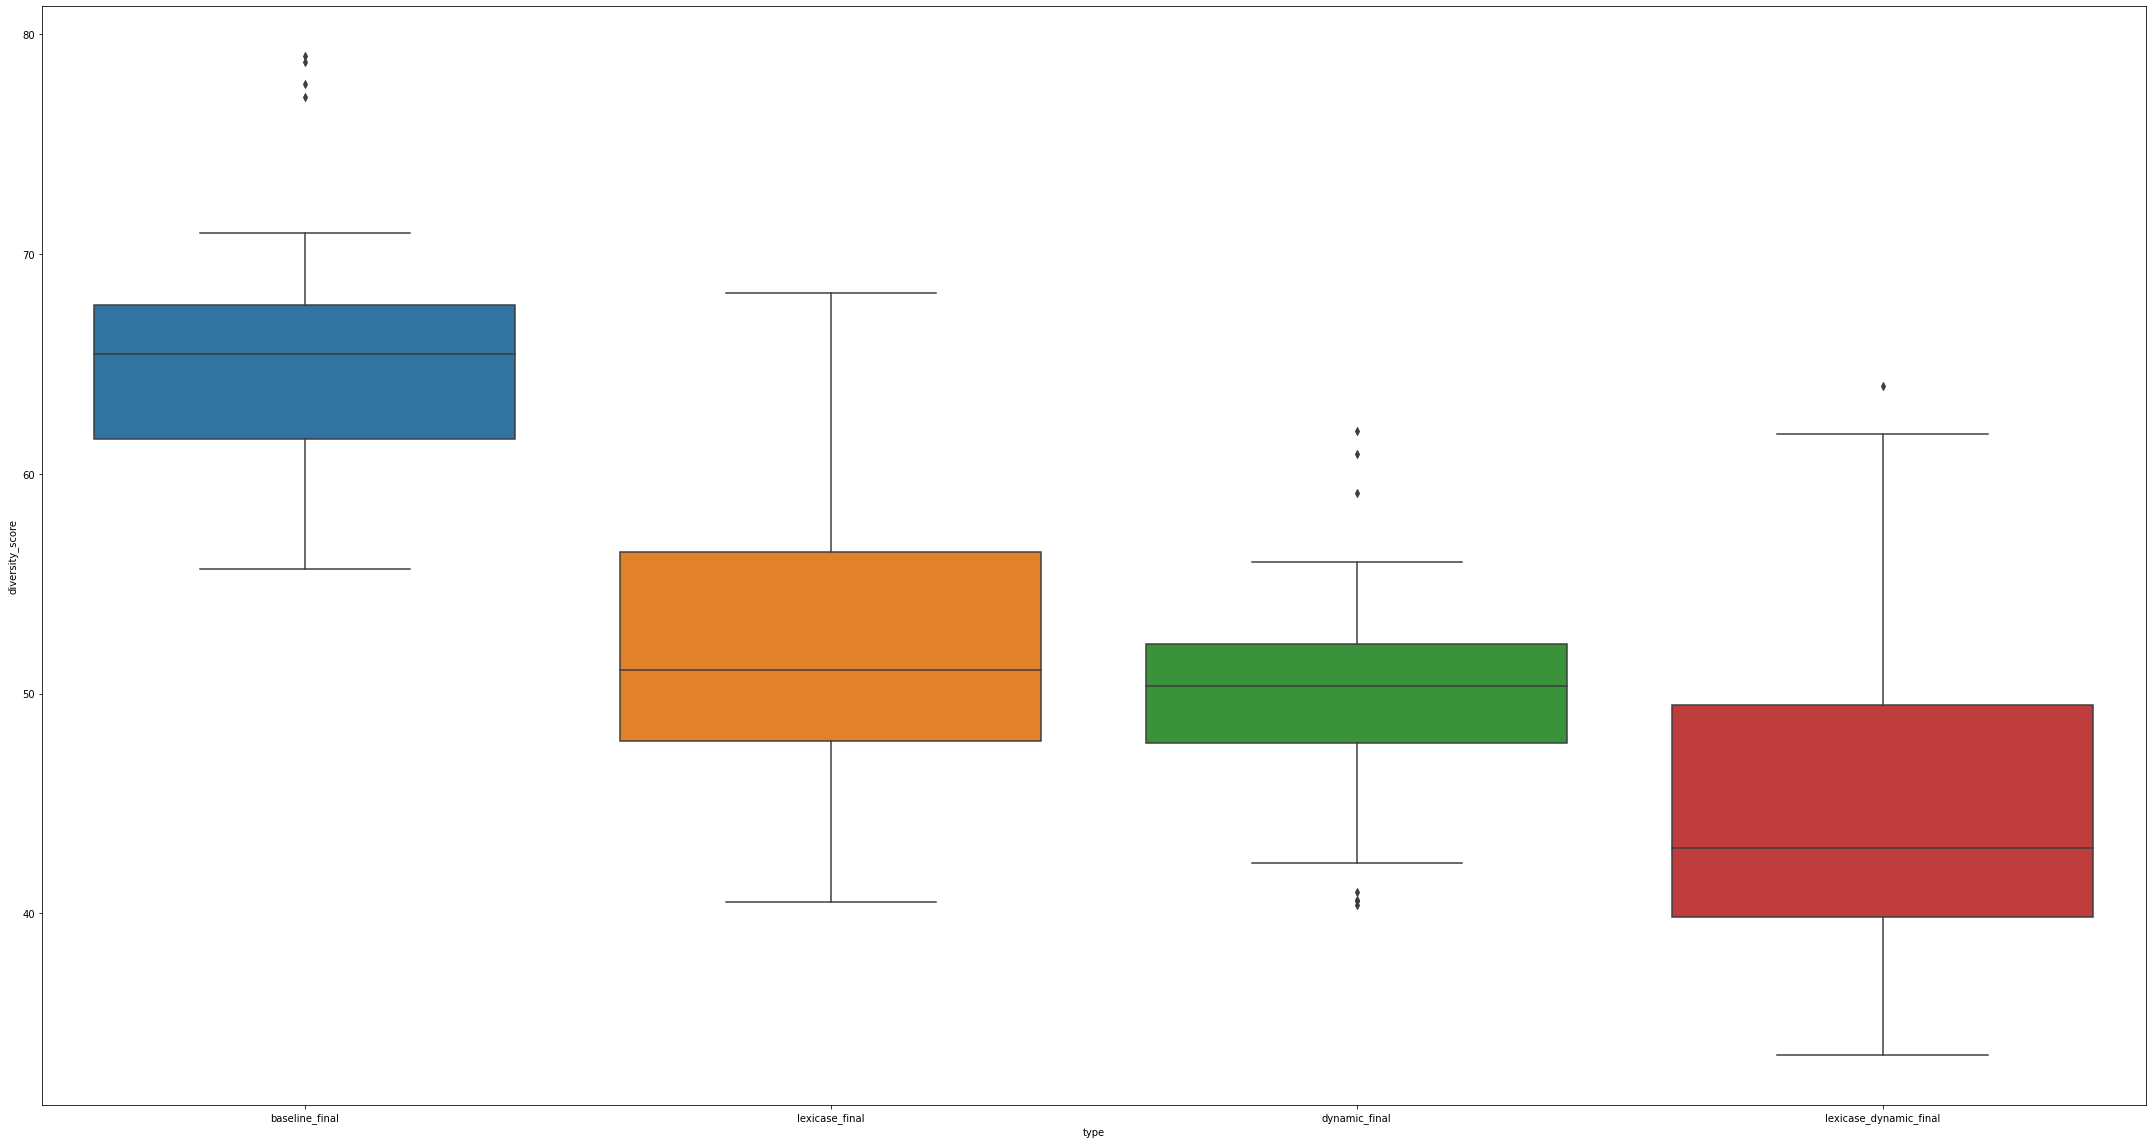

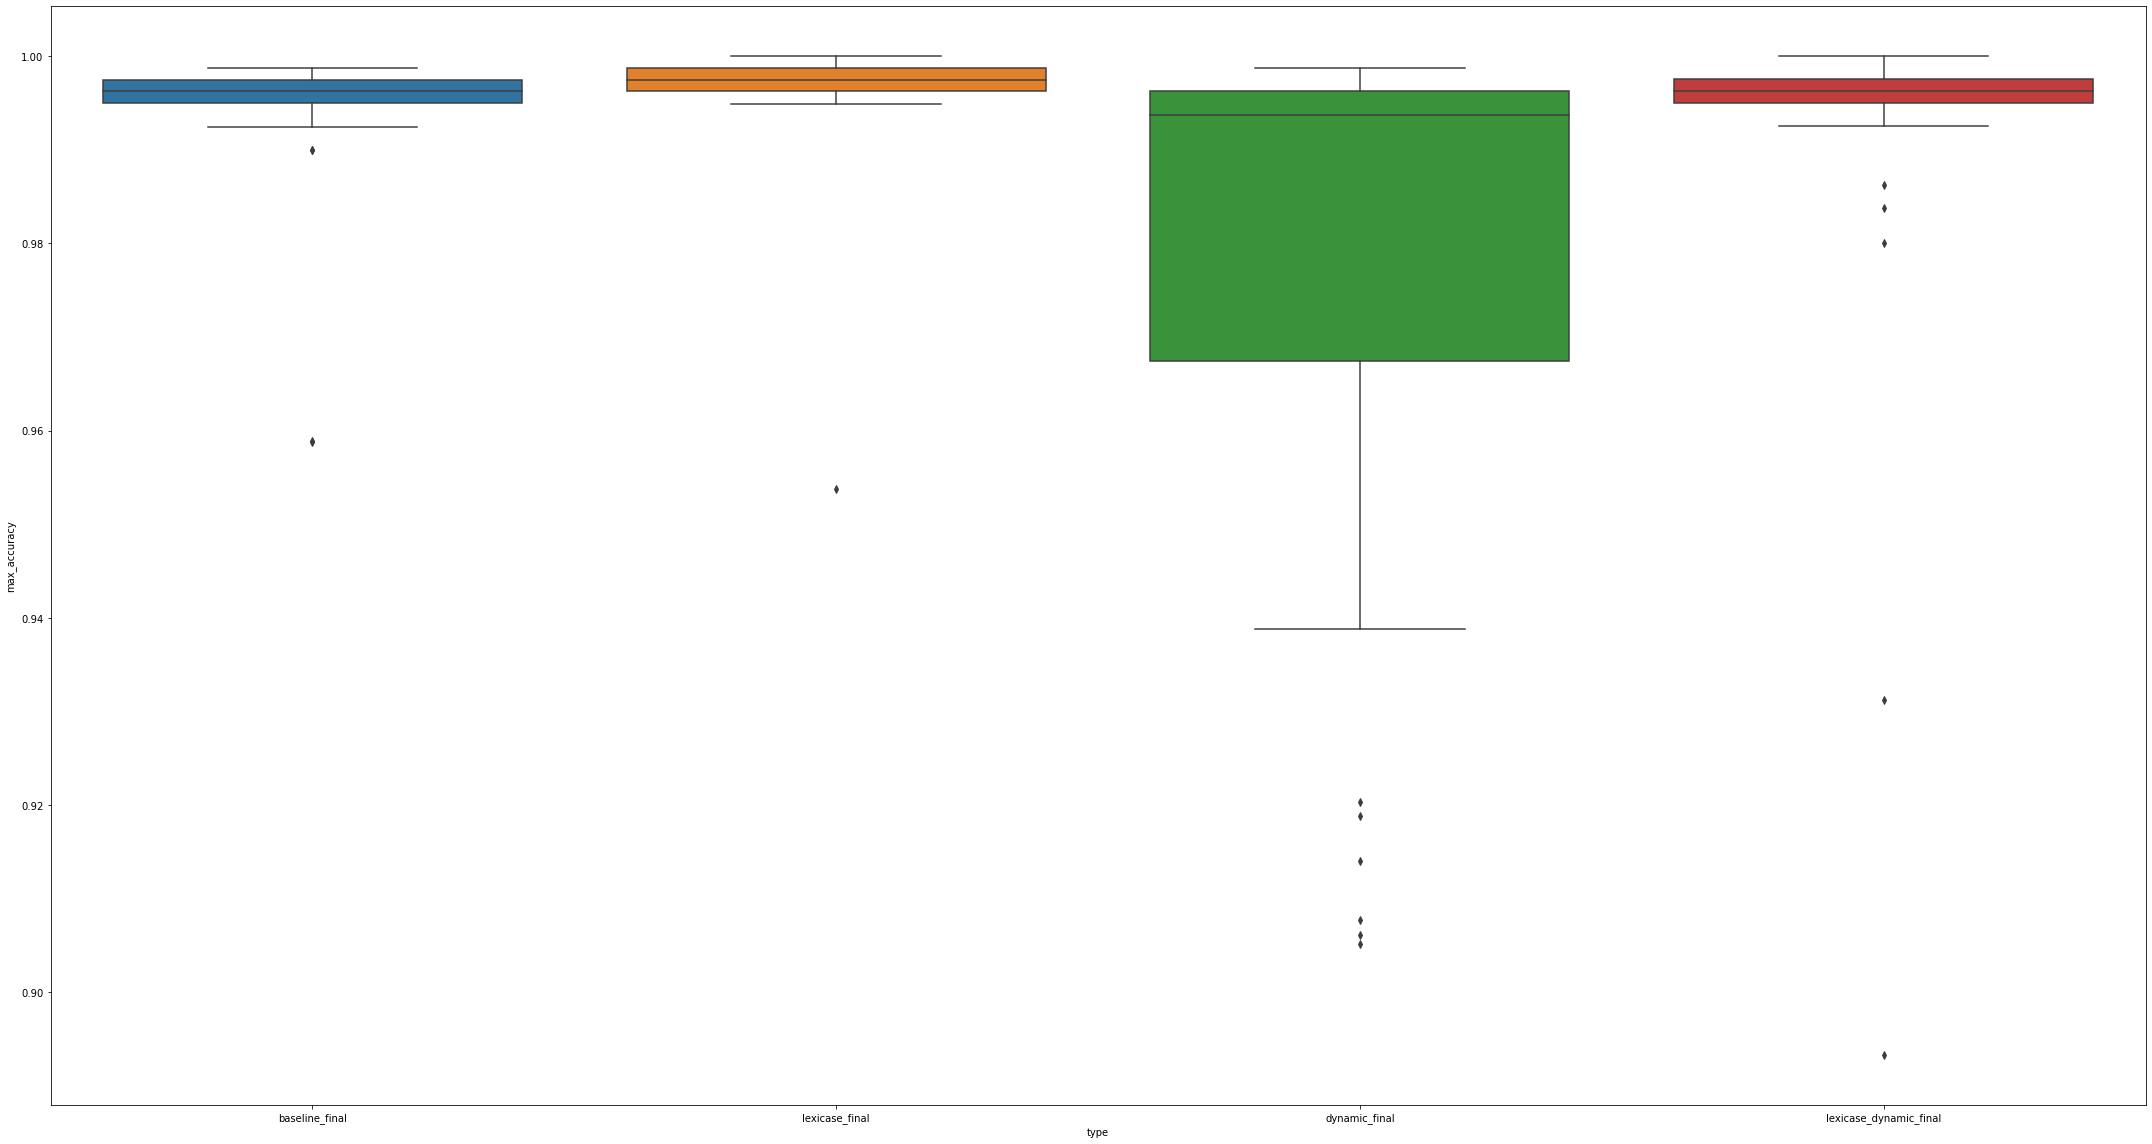

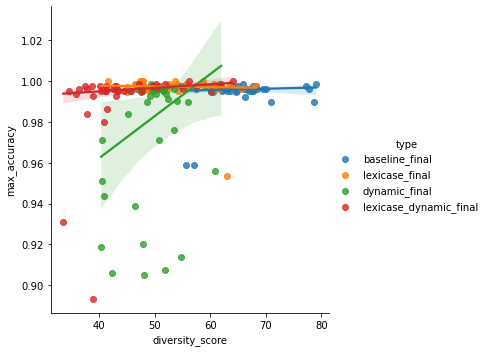

23


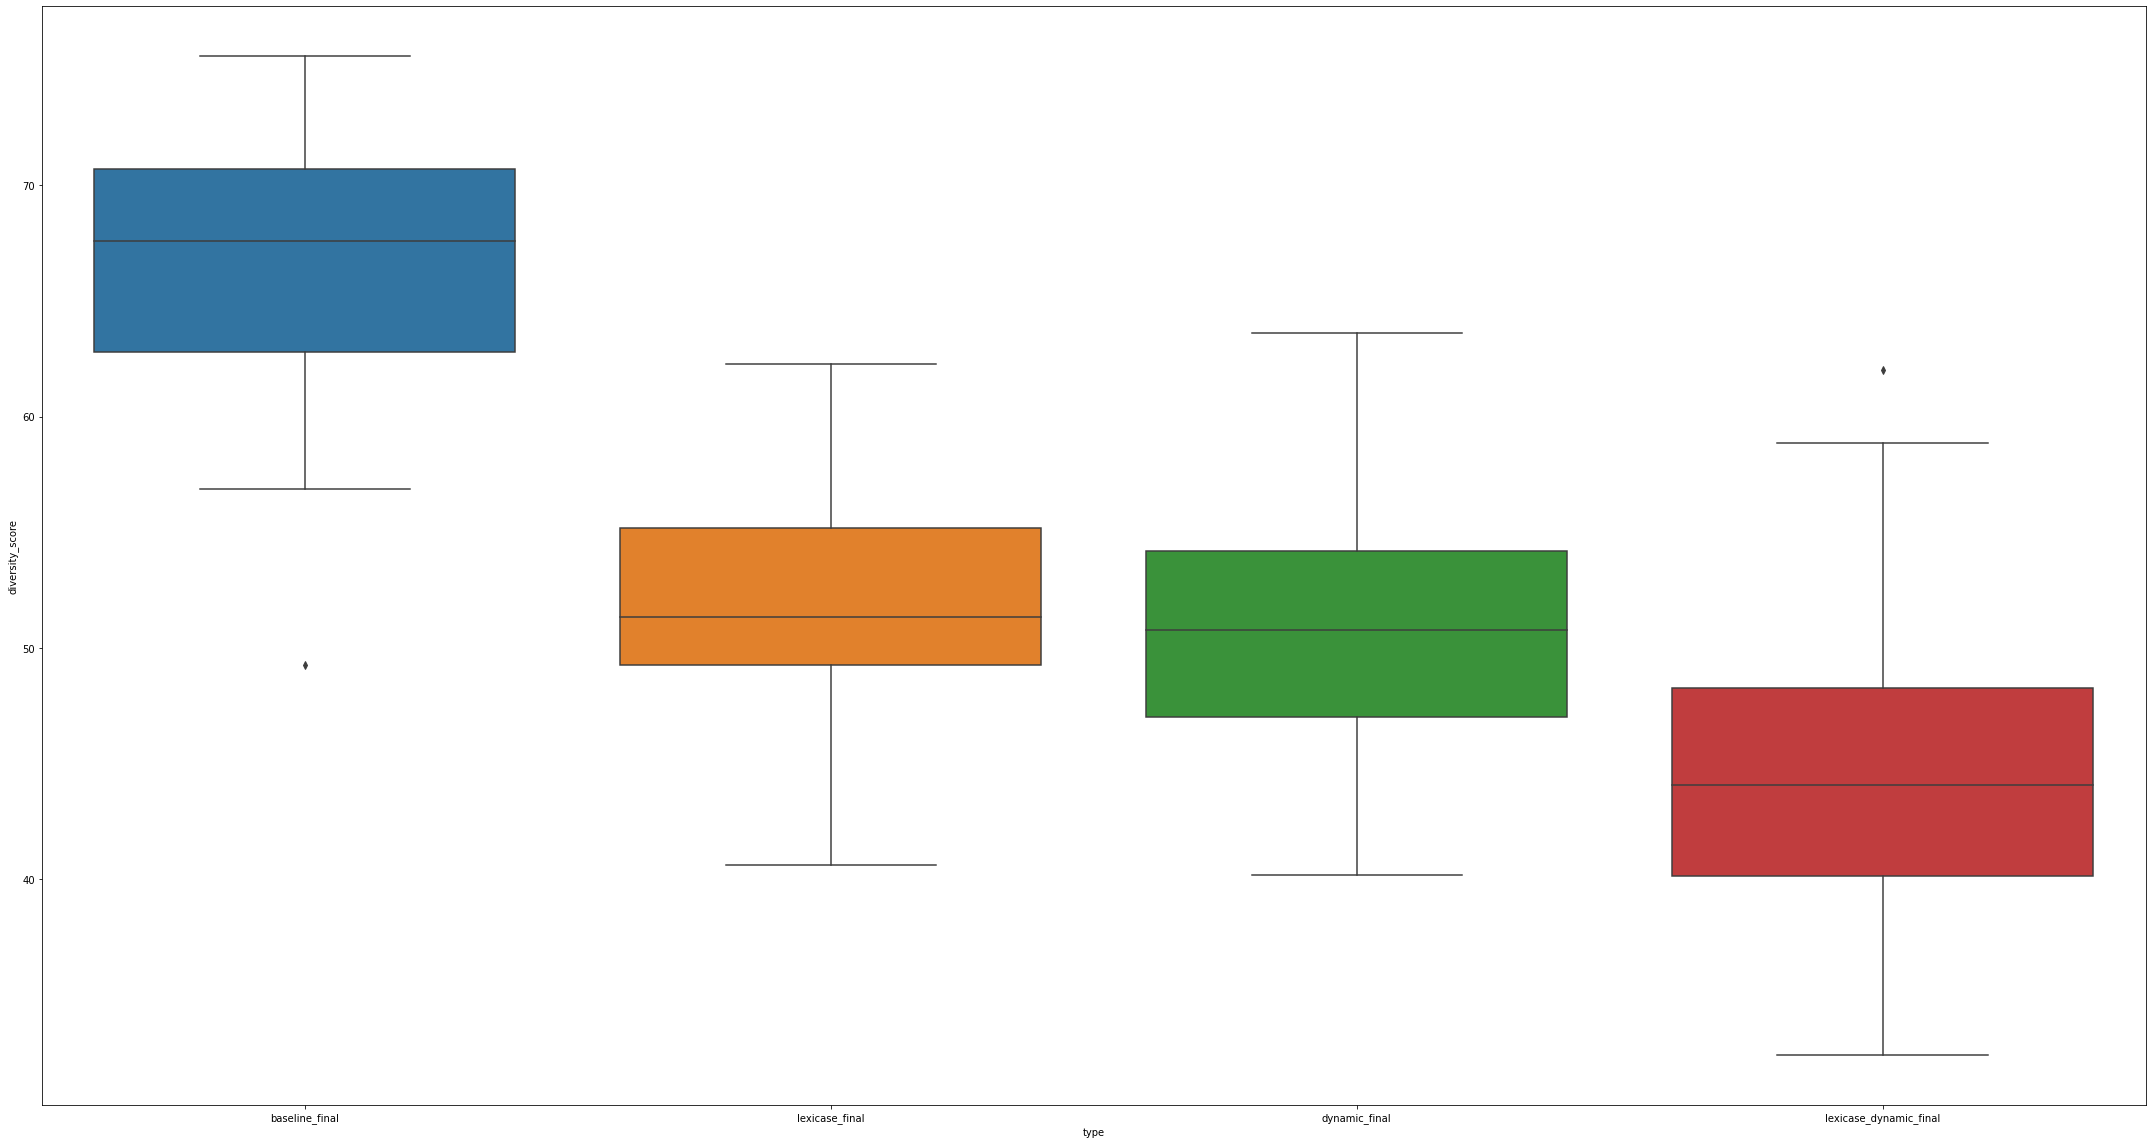

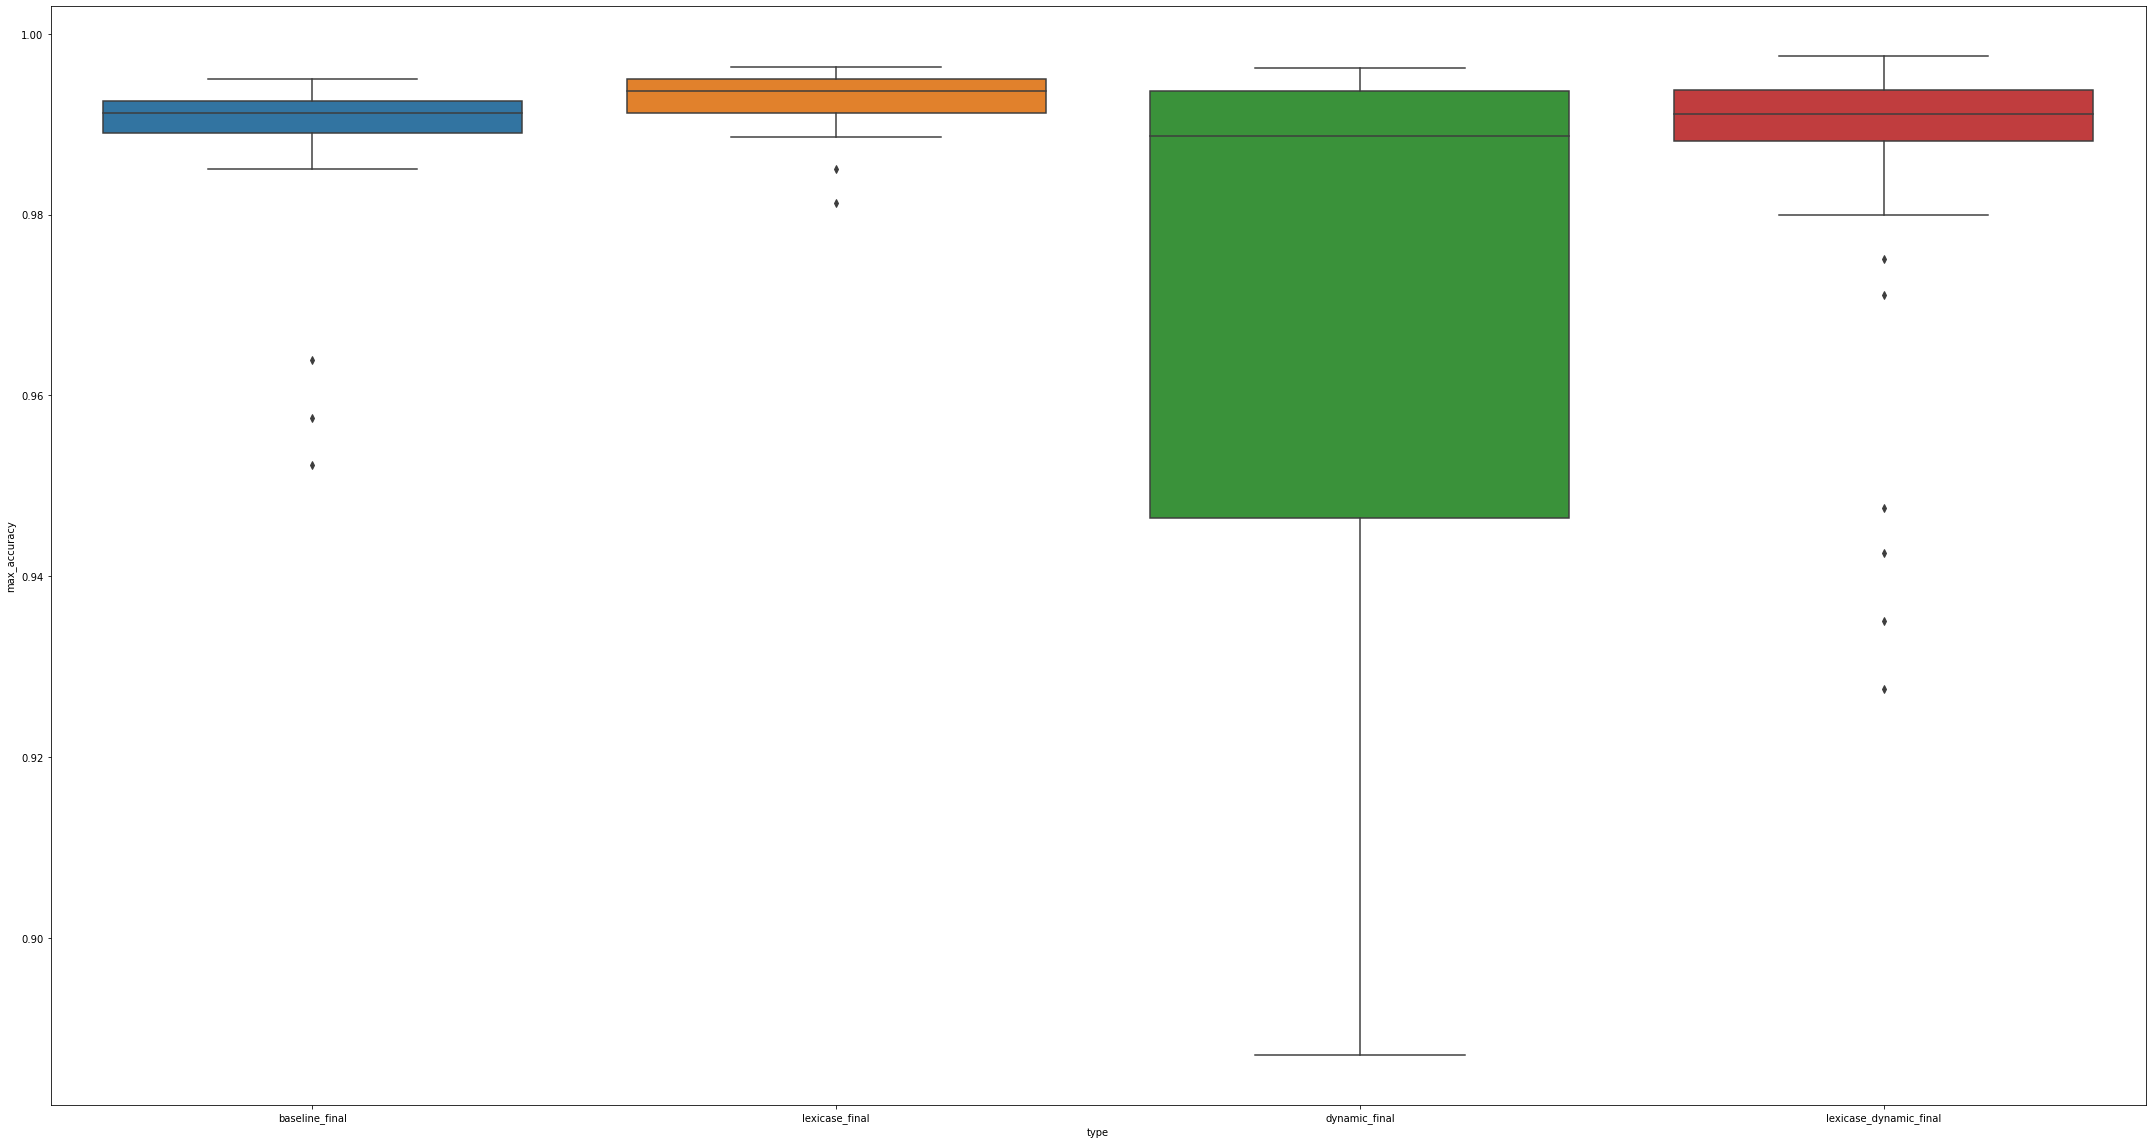

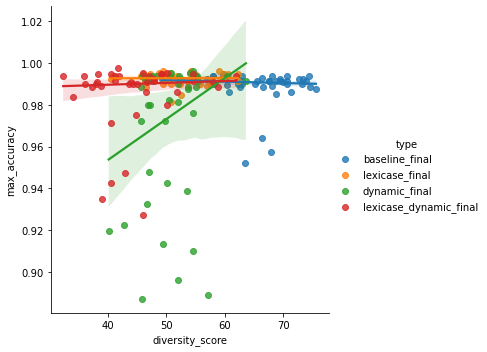

24


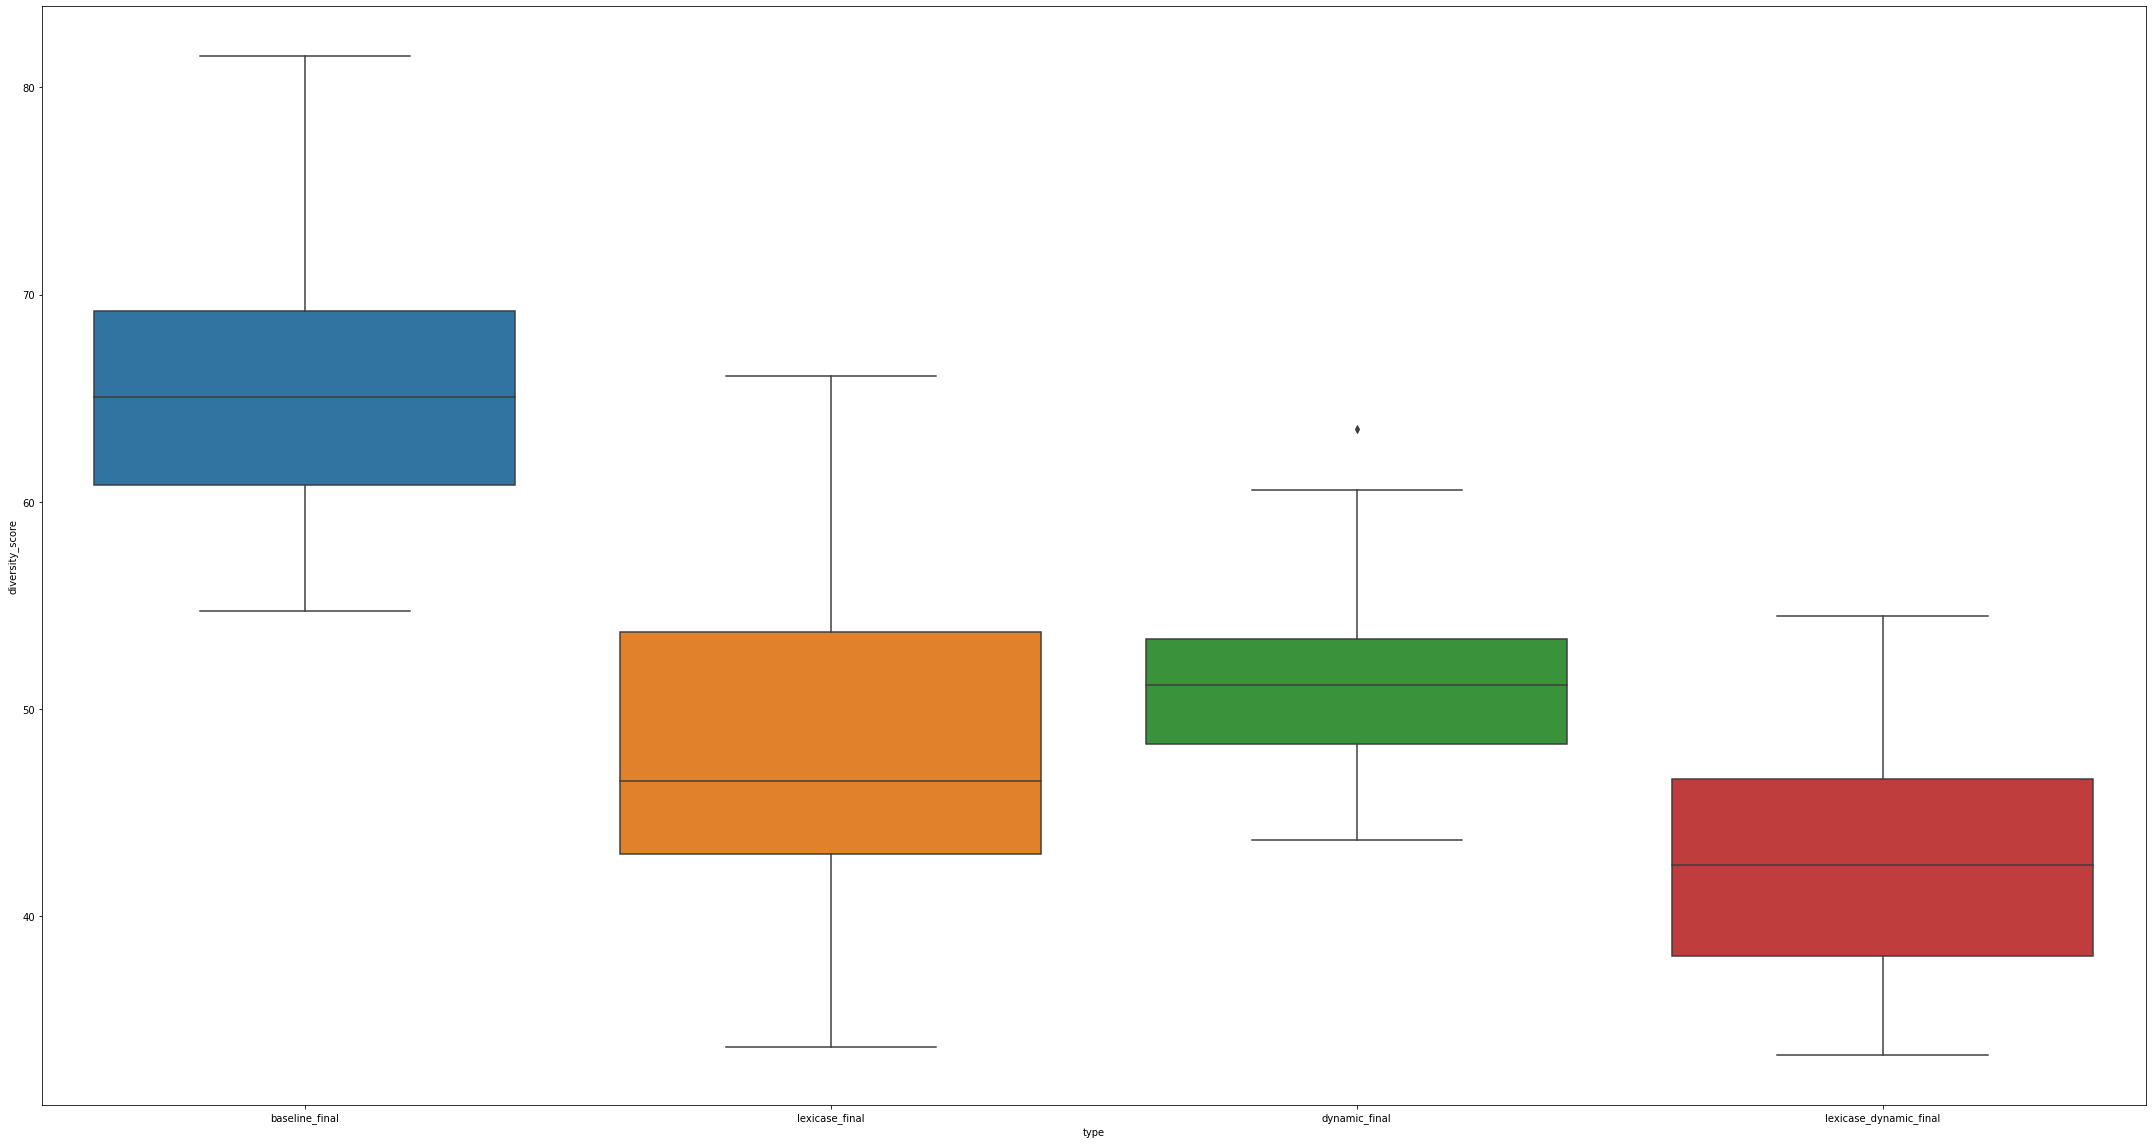

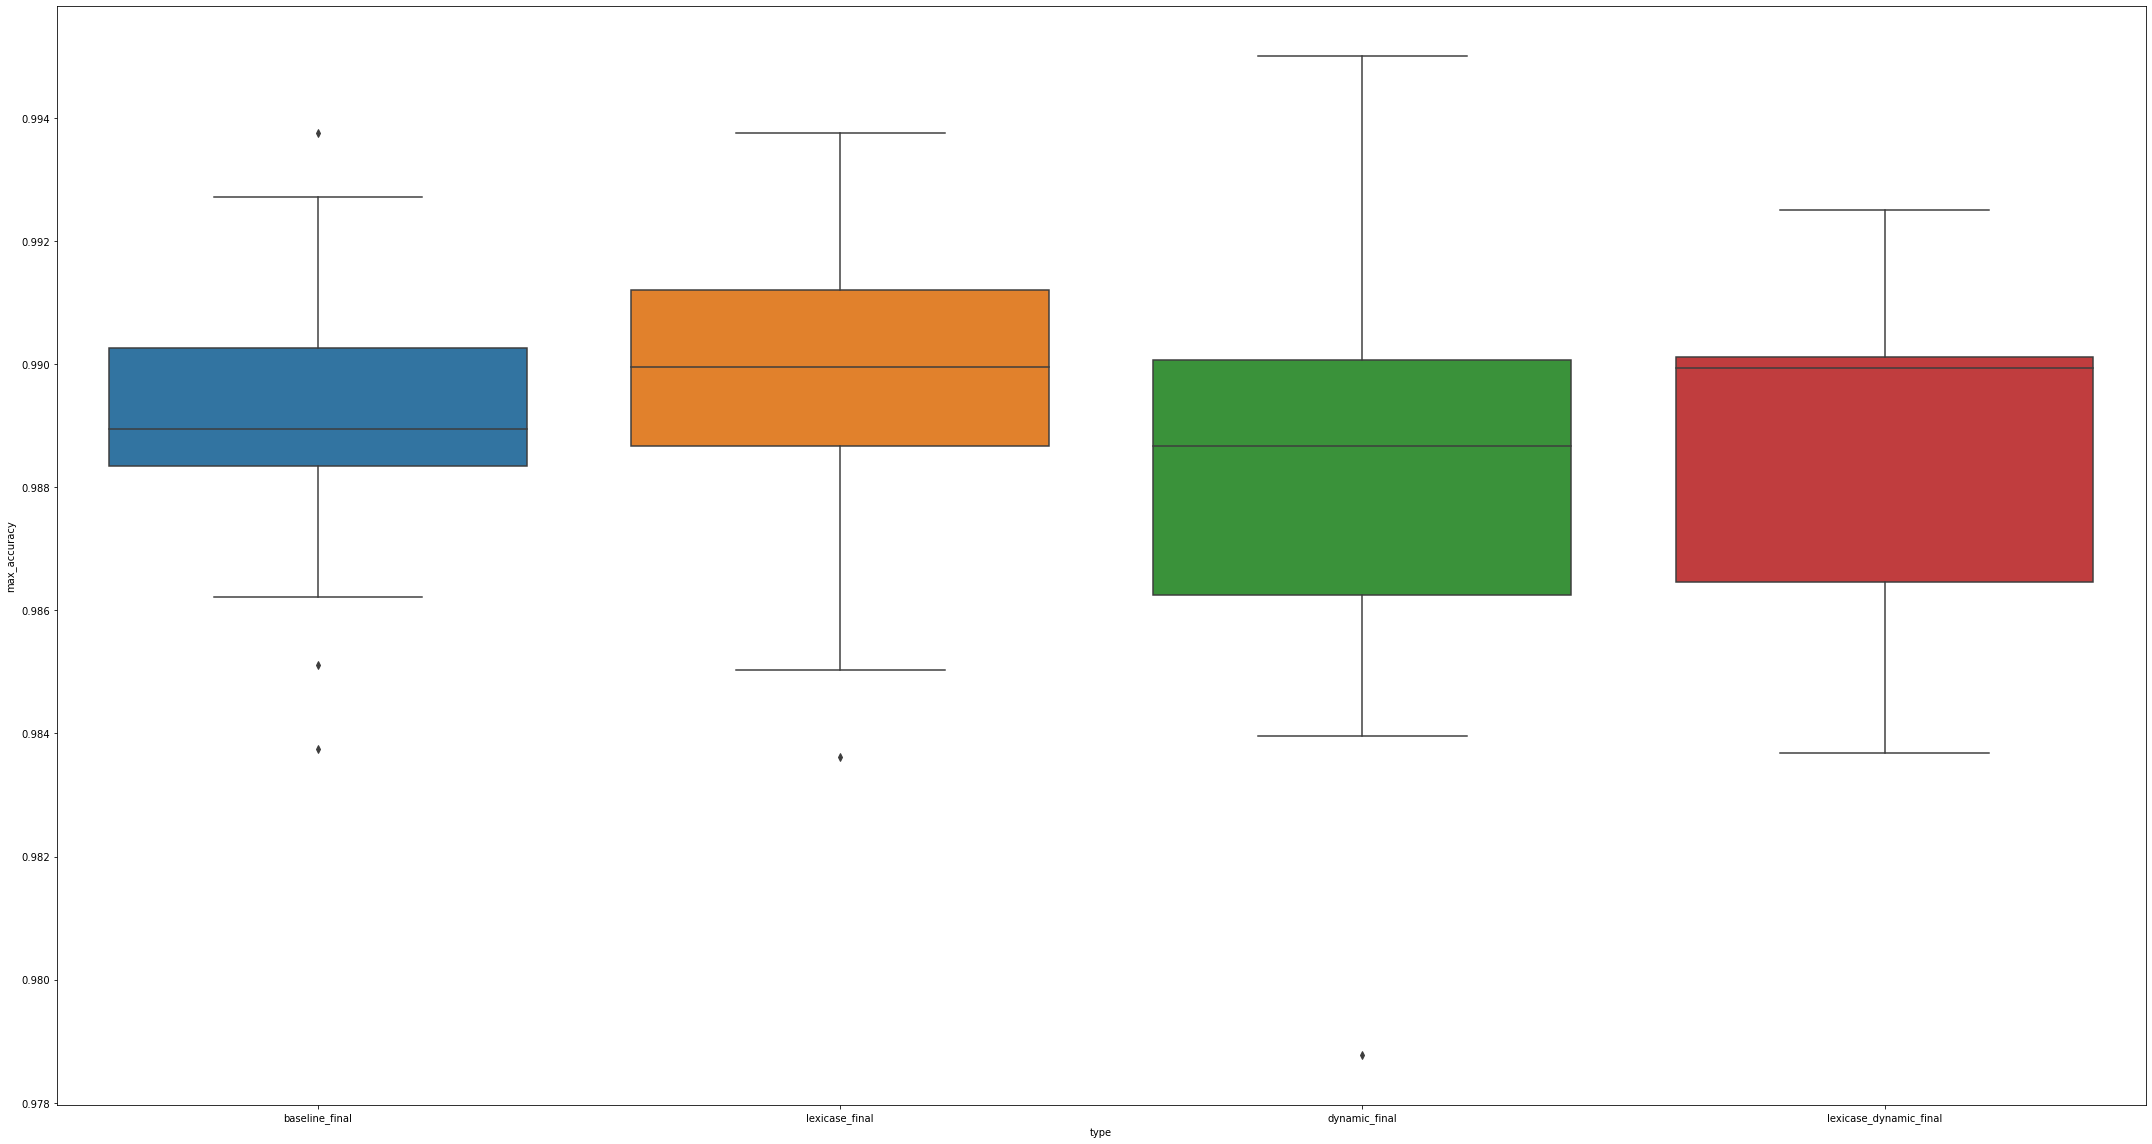

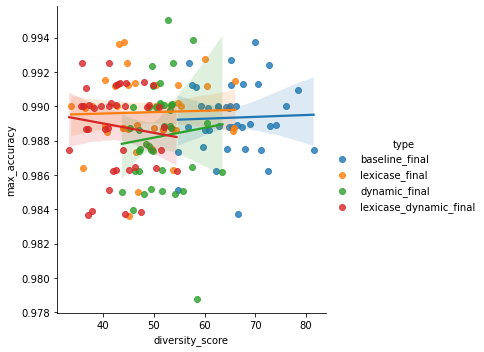

25


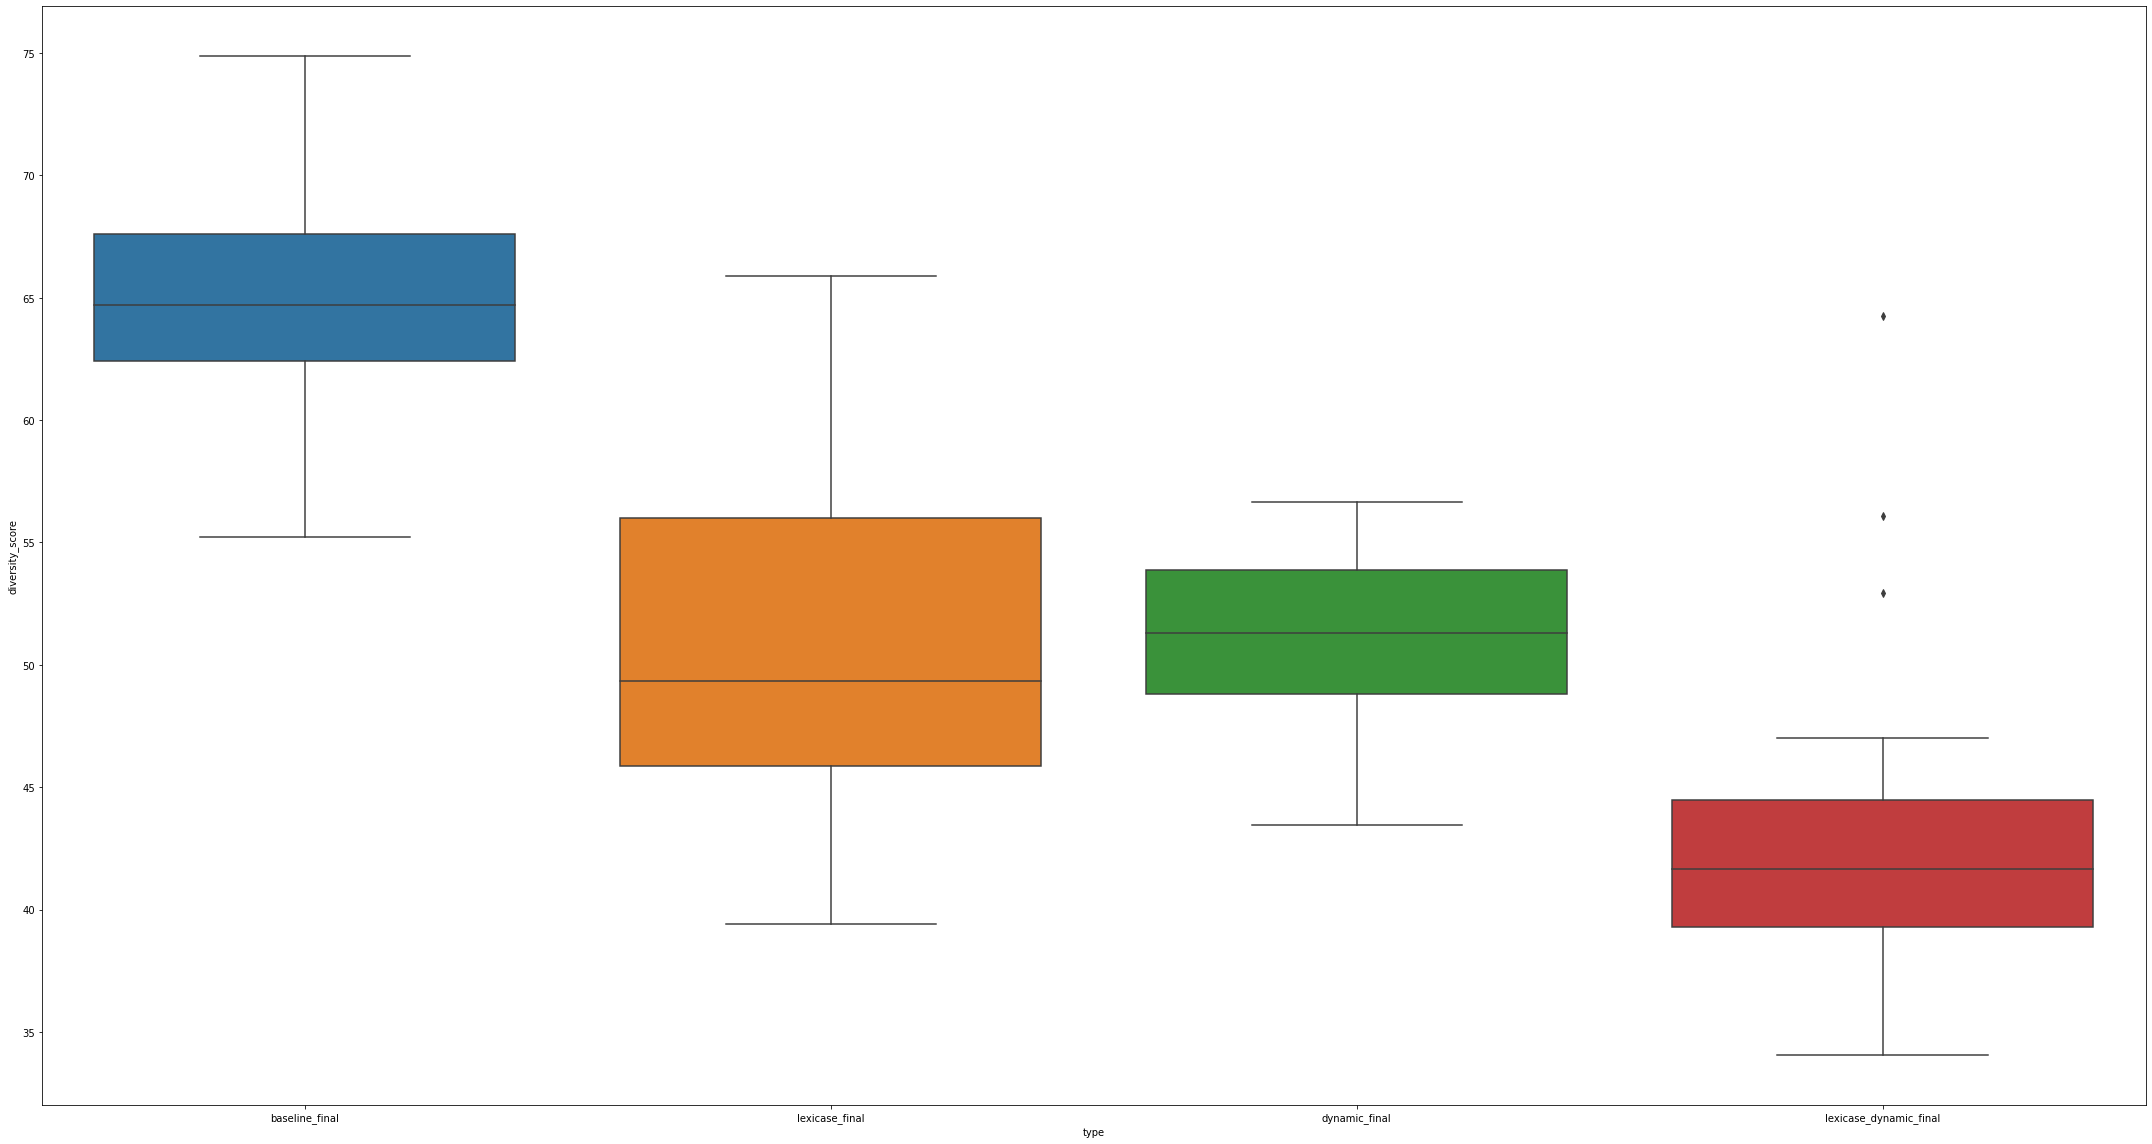

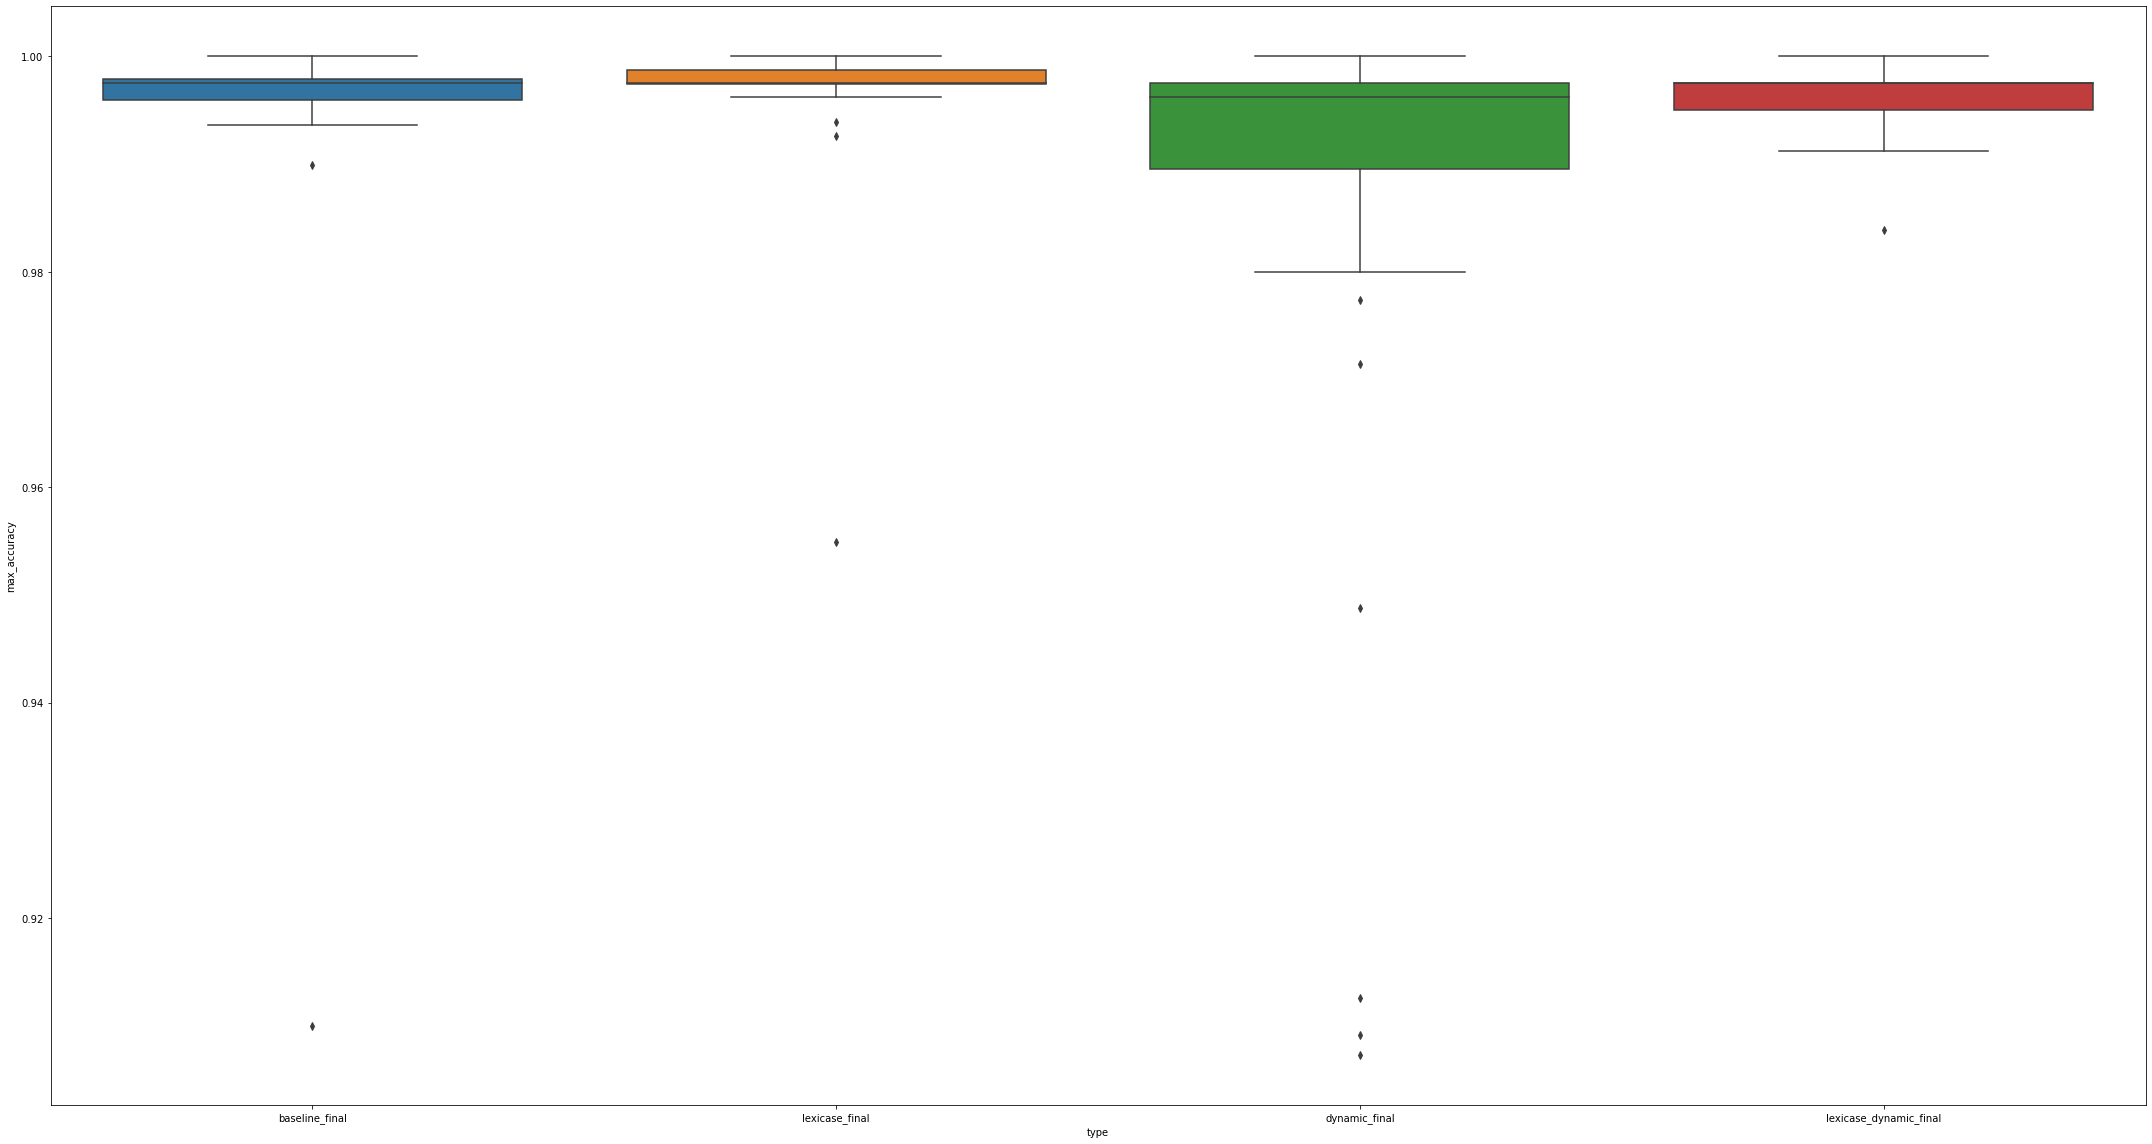

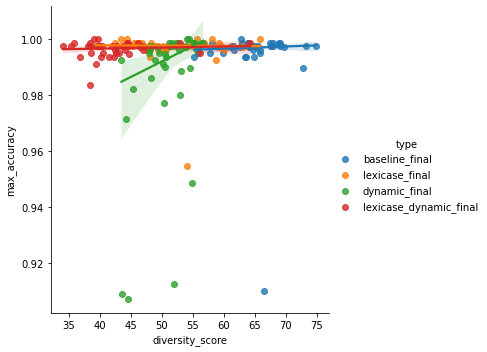

27


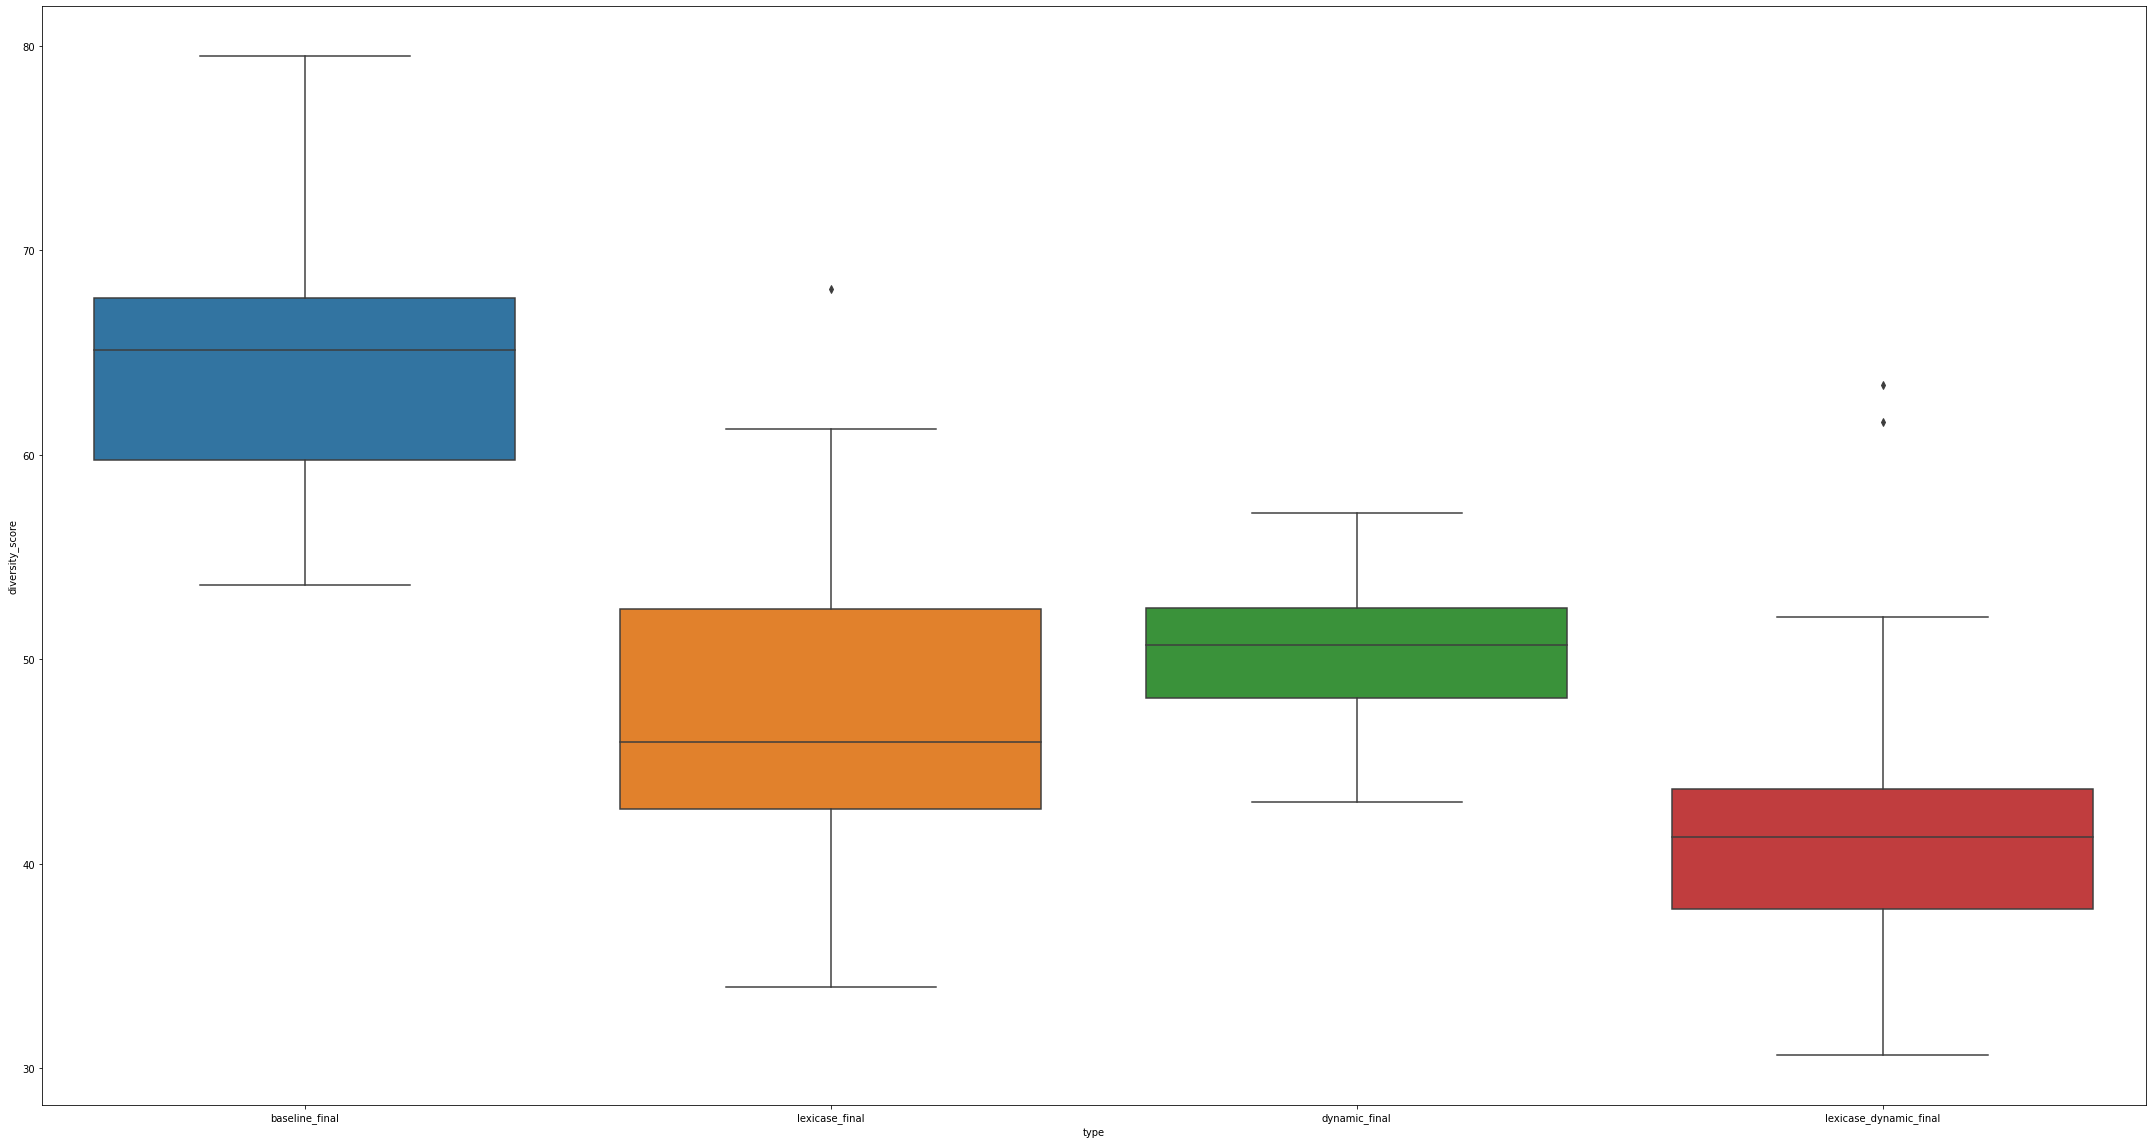

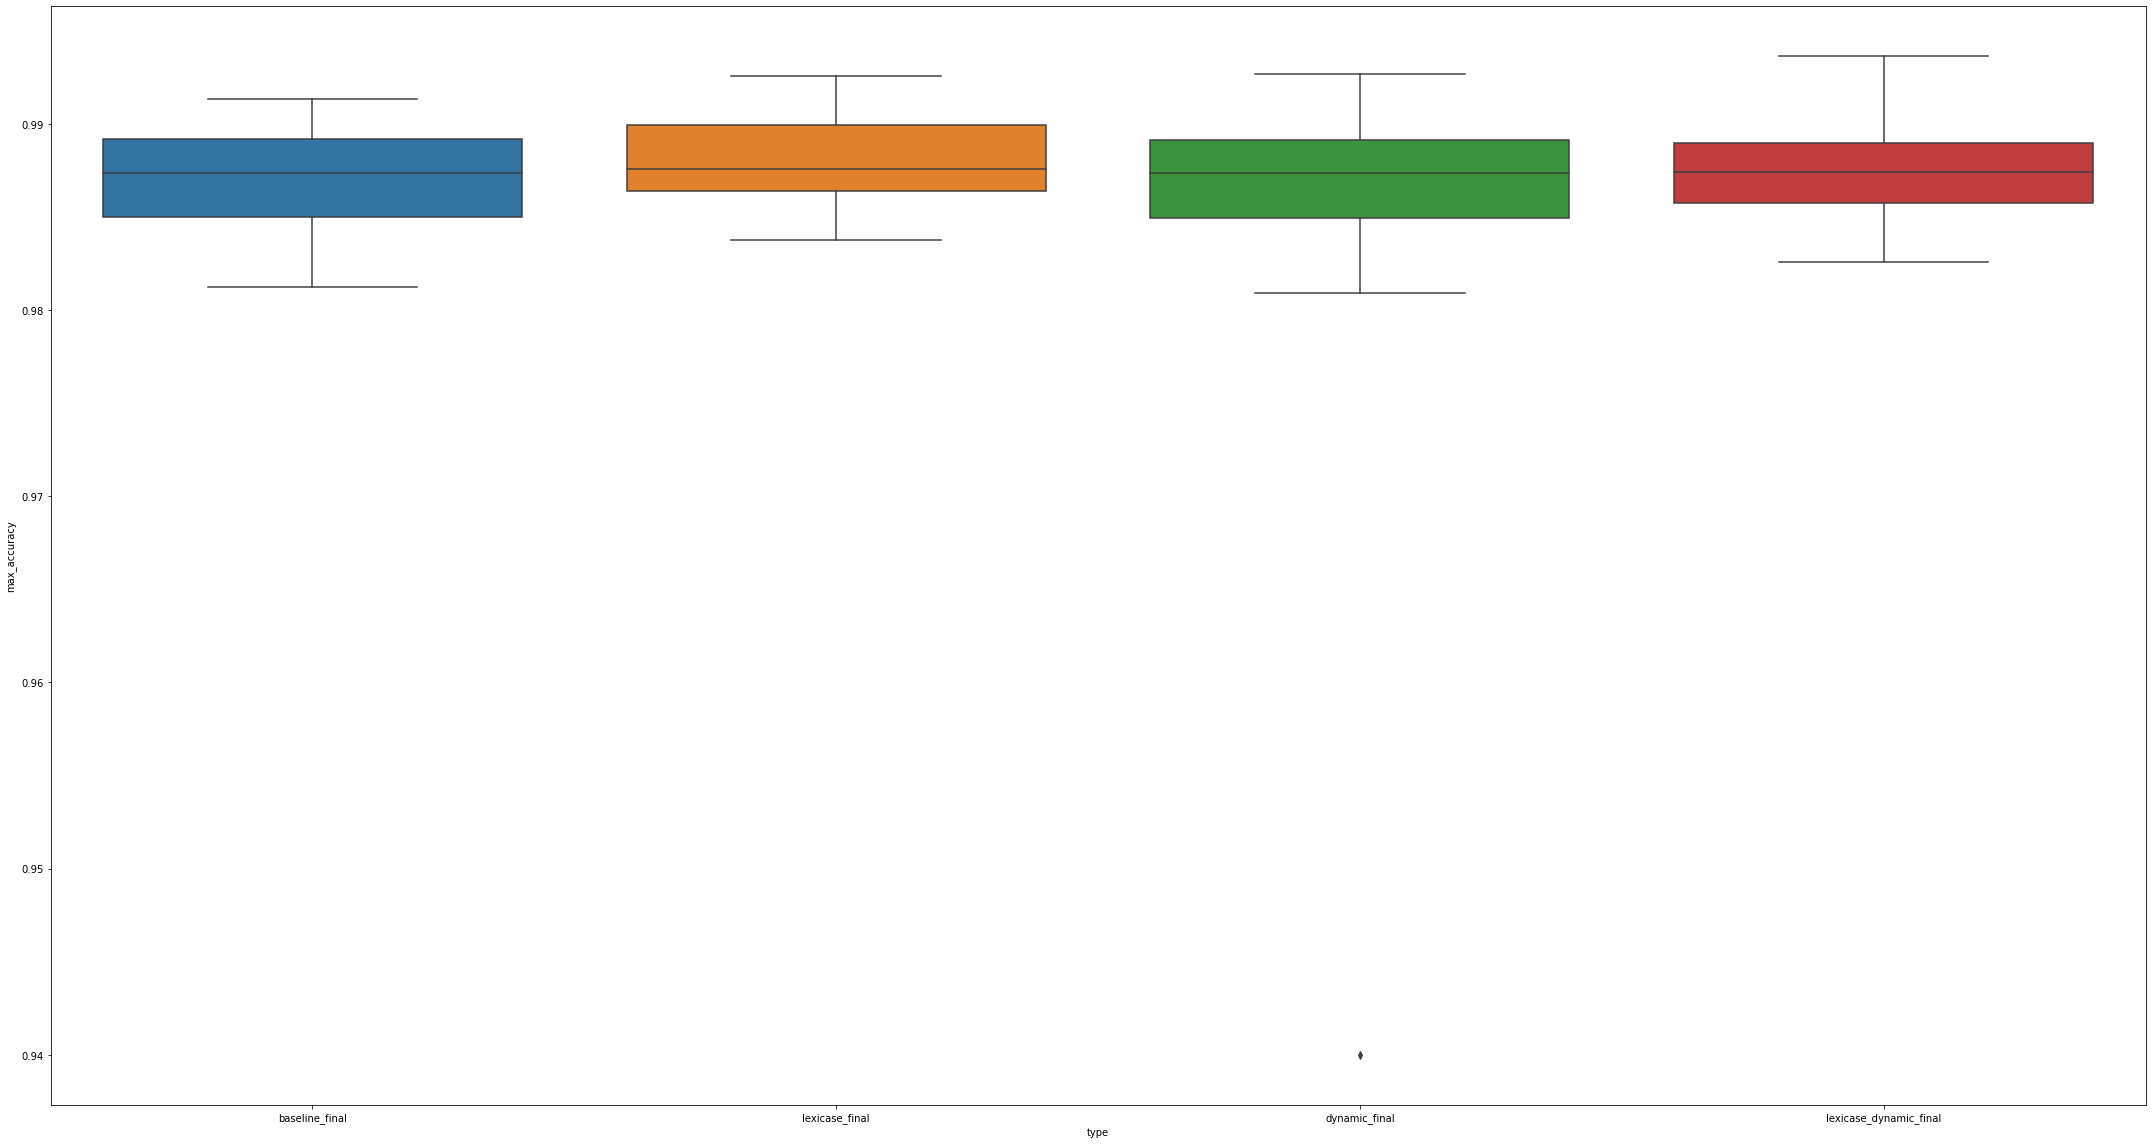

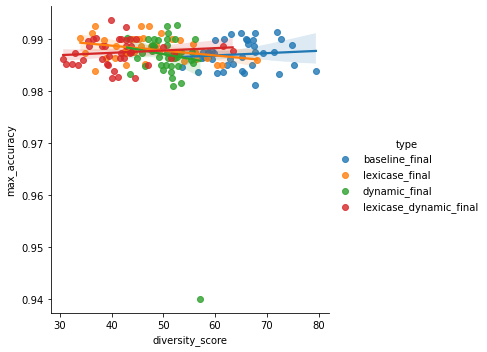

28


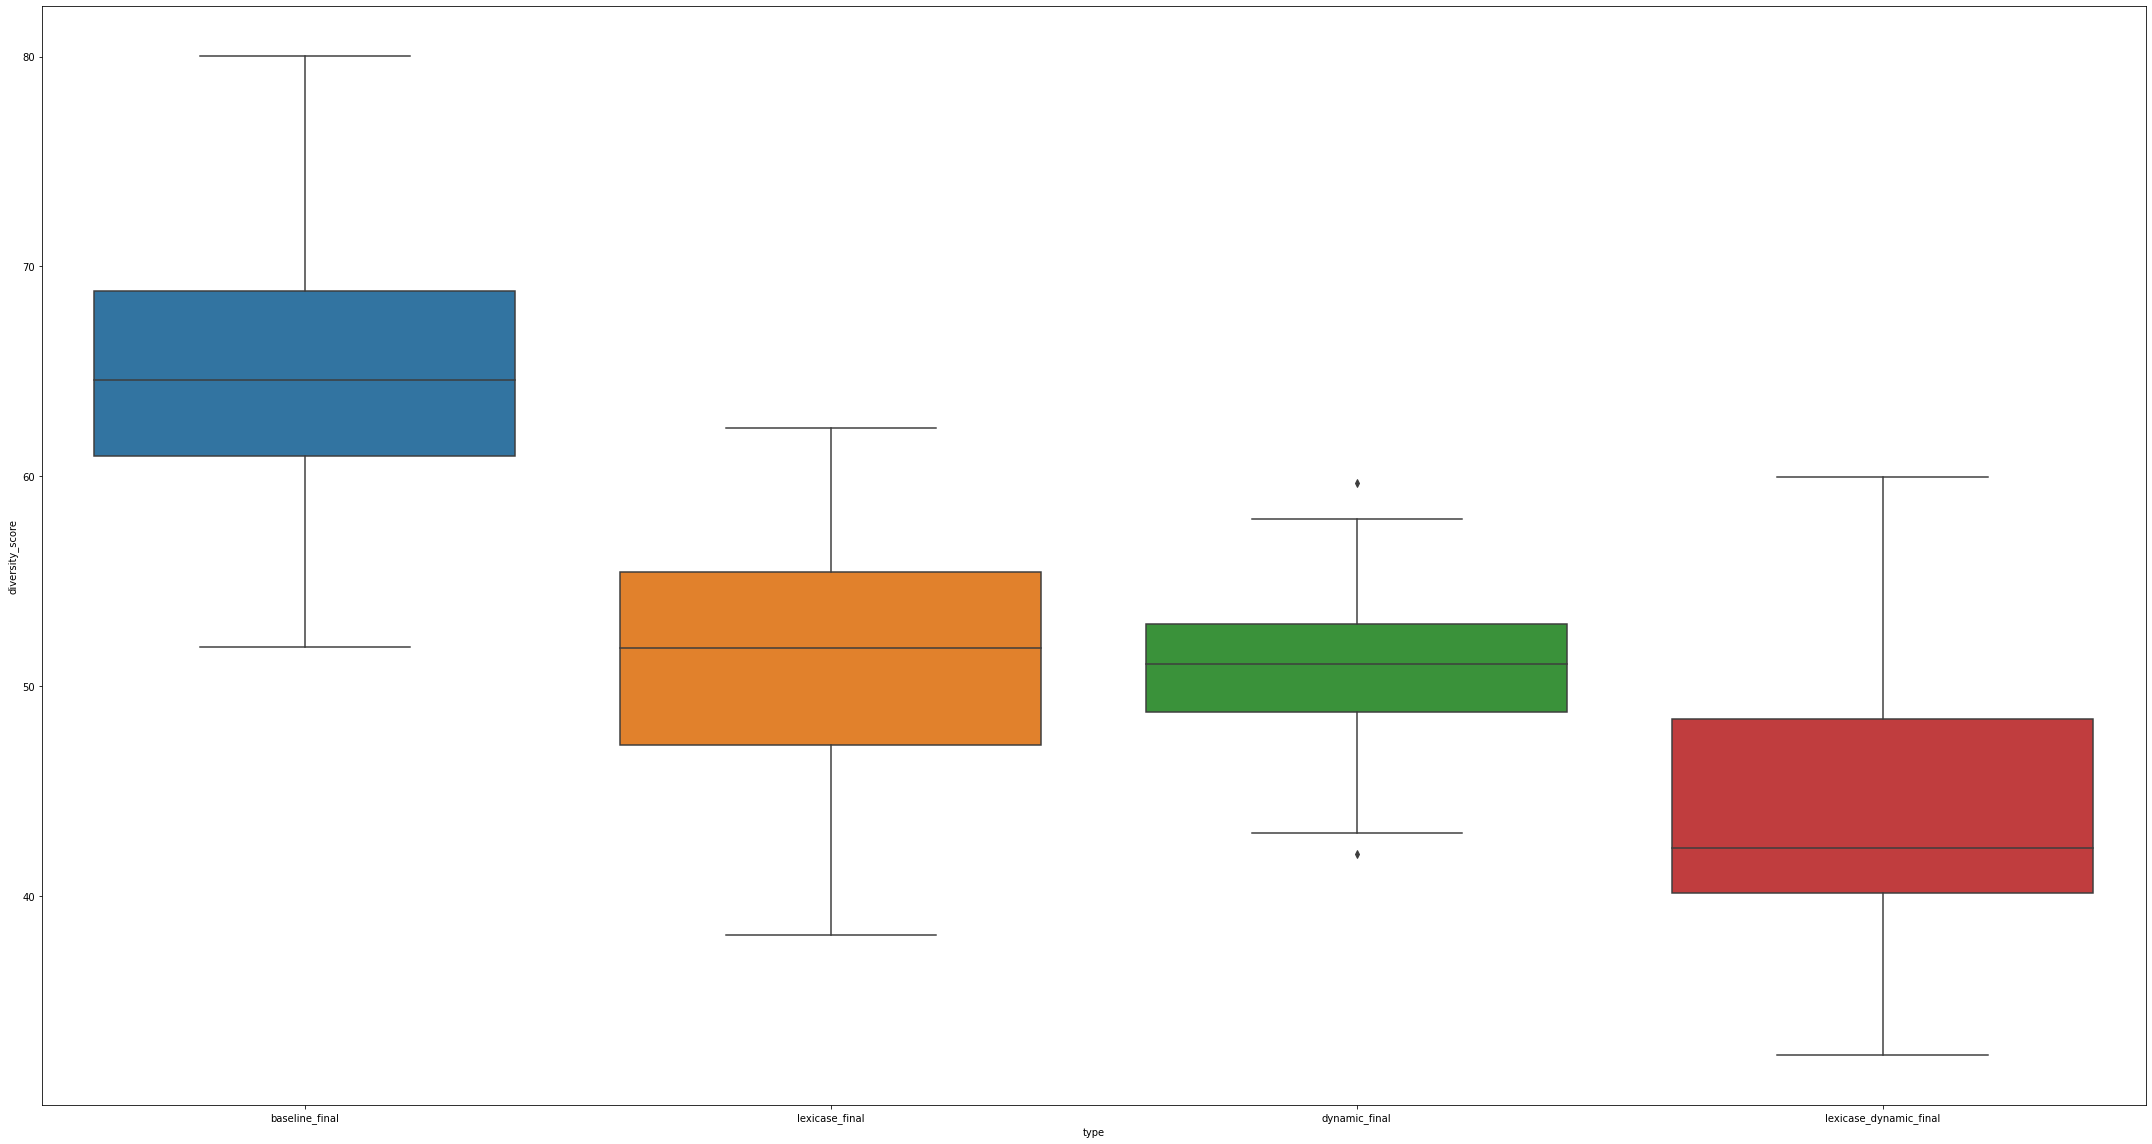

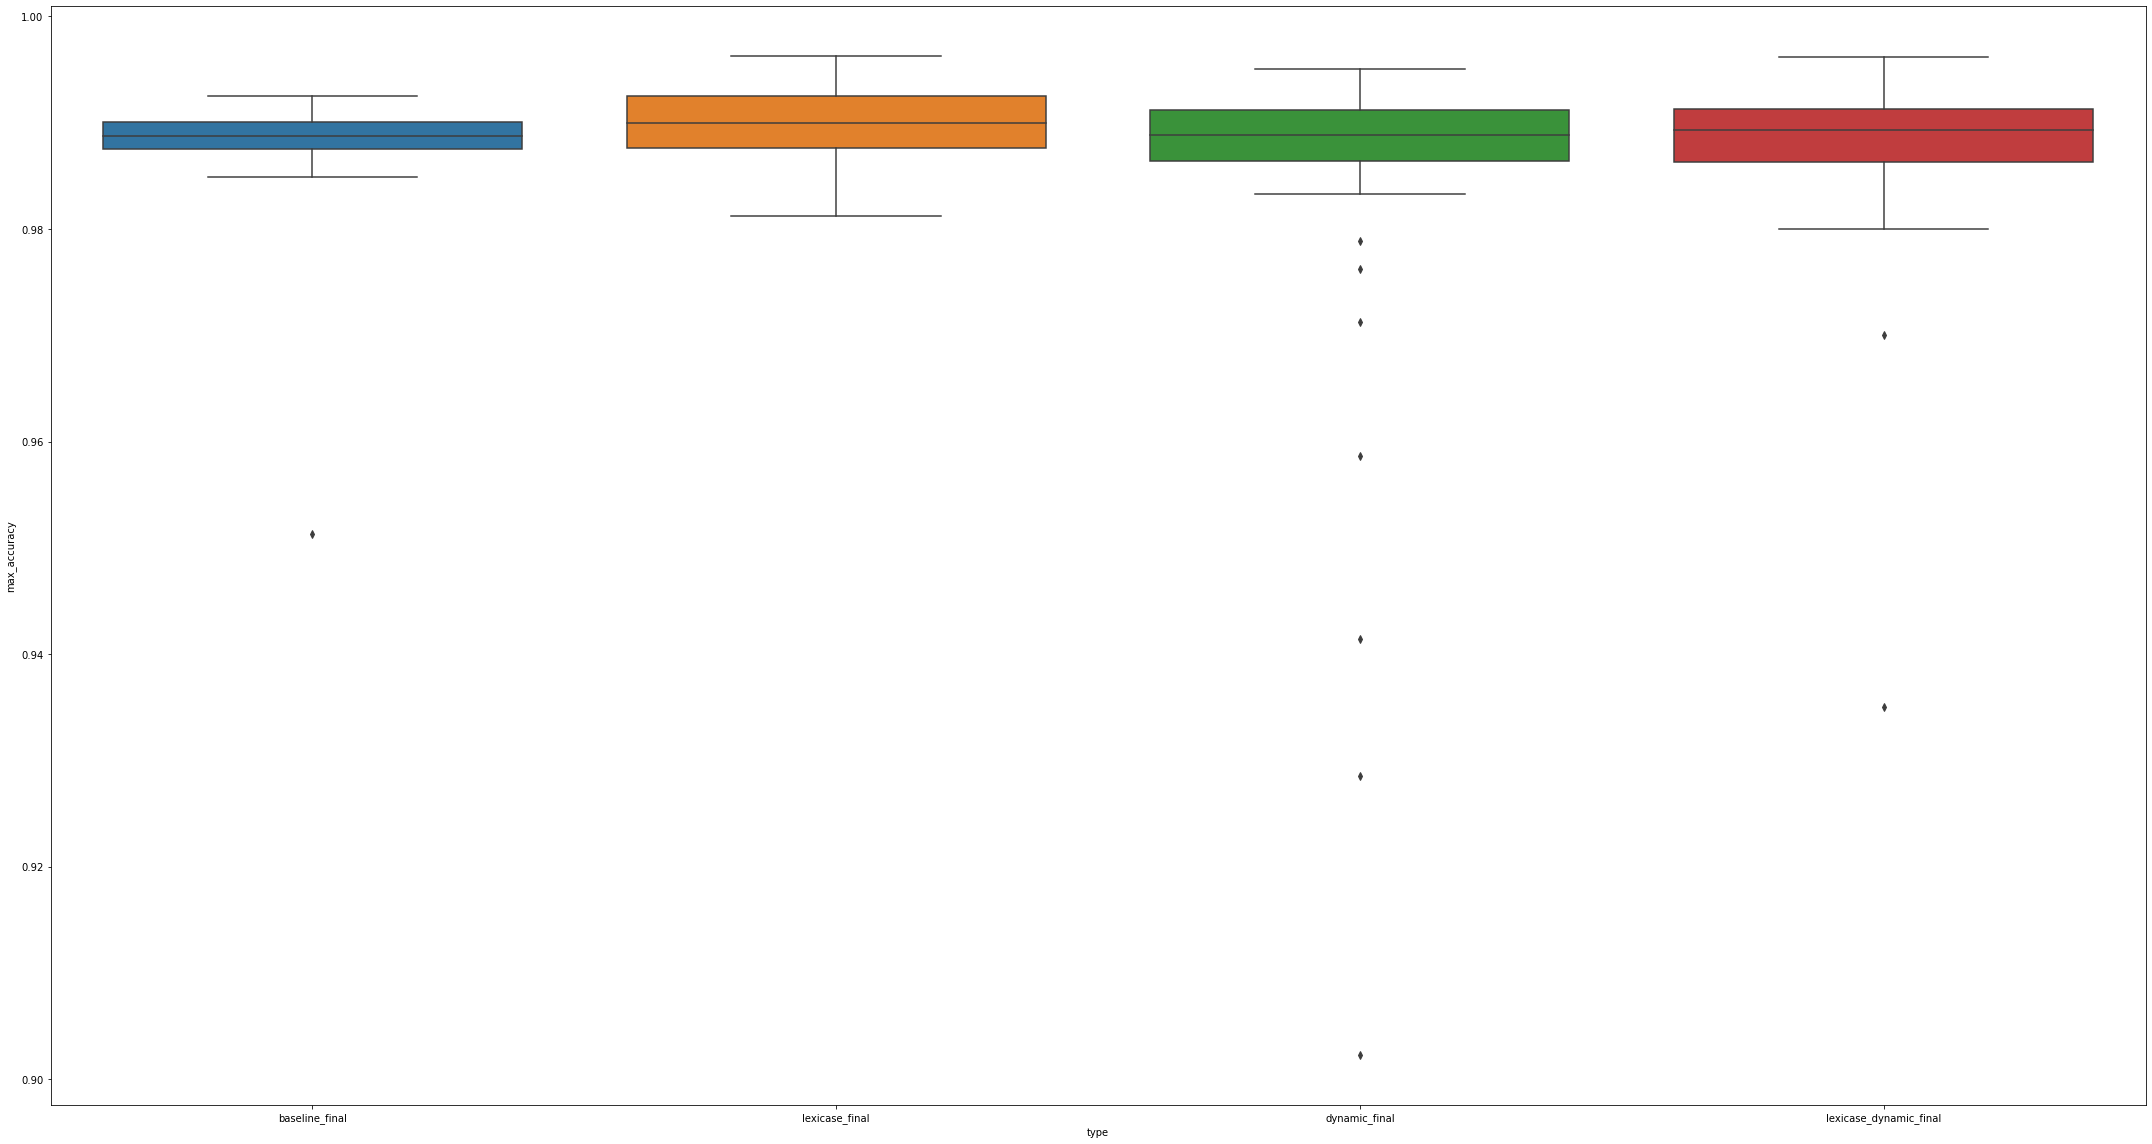

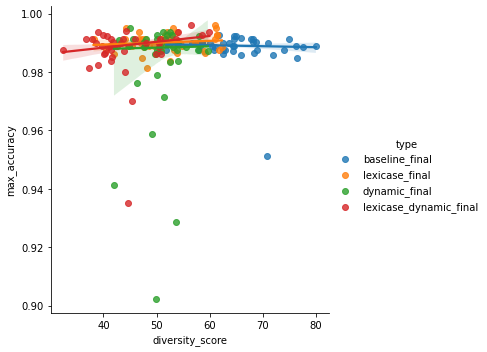

30


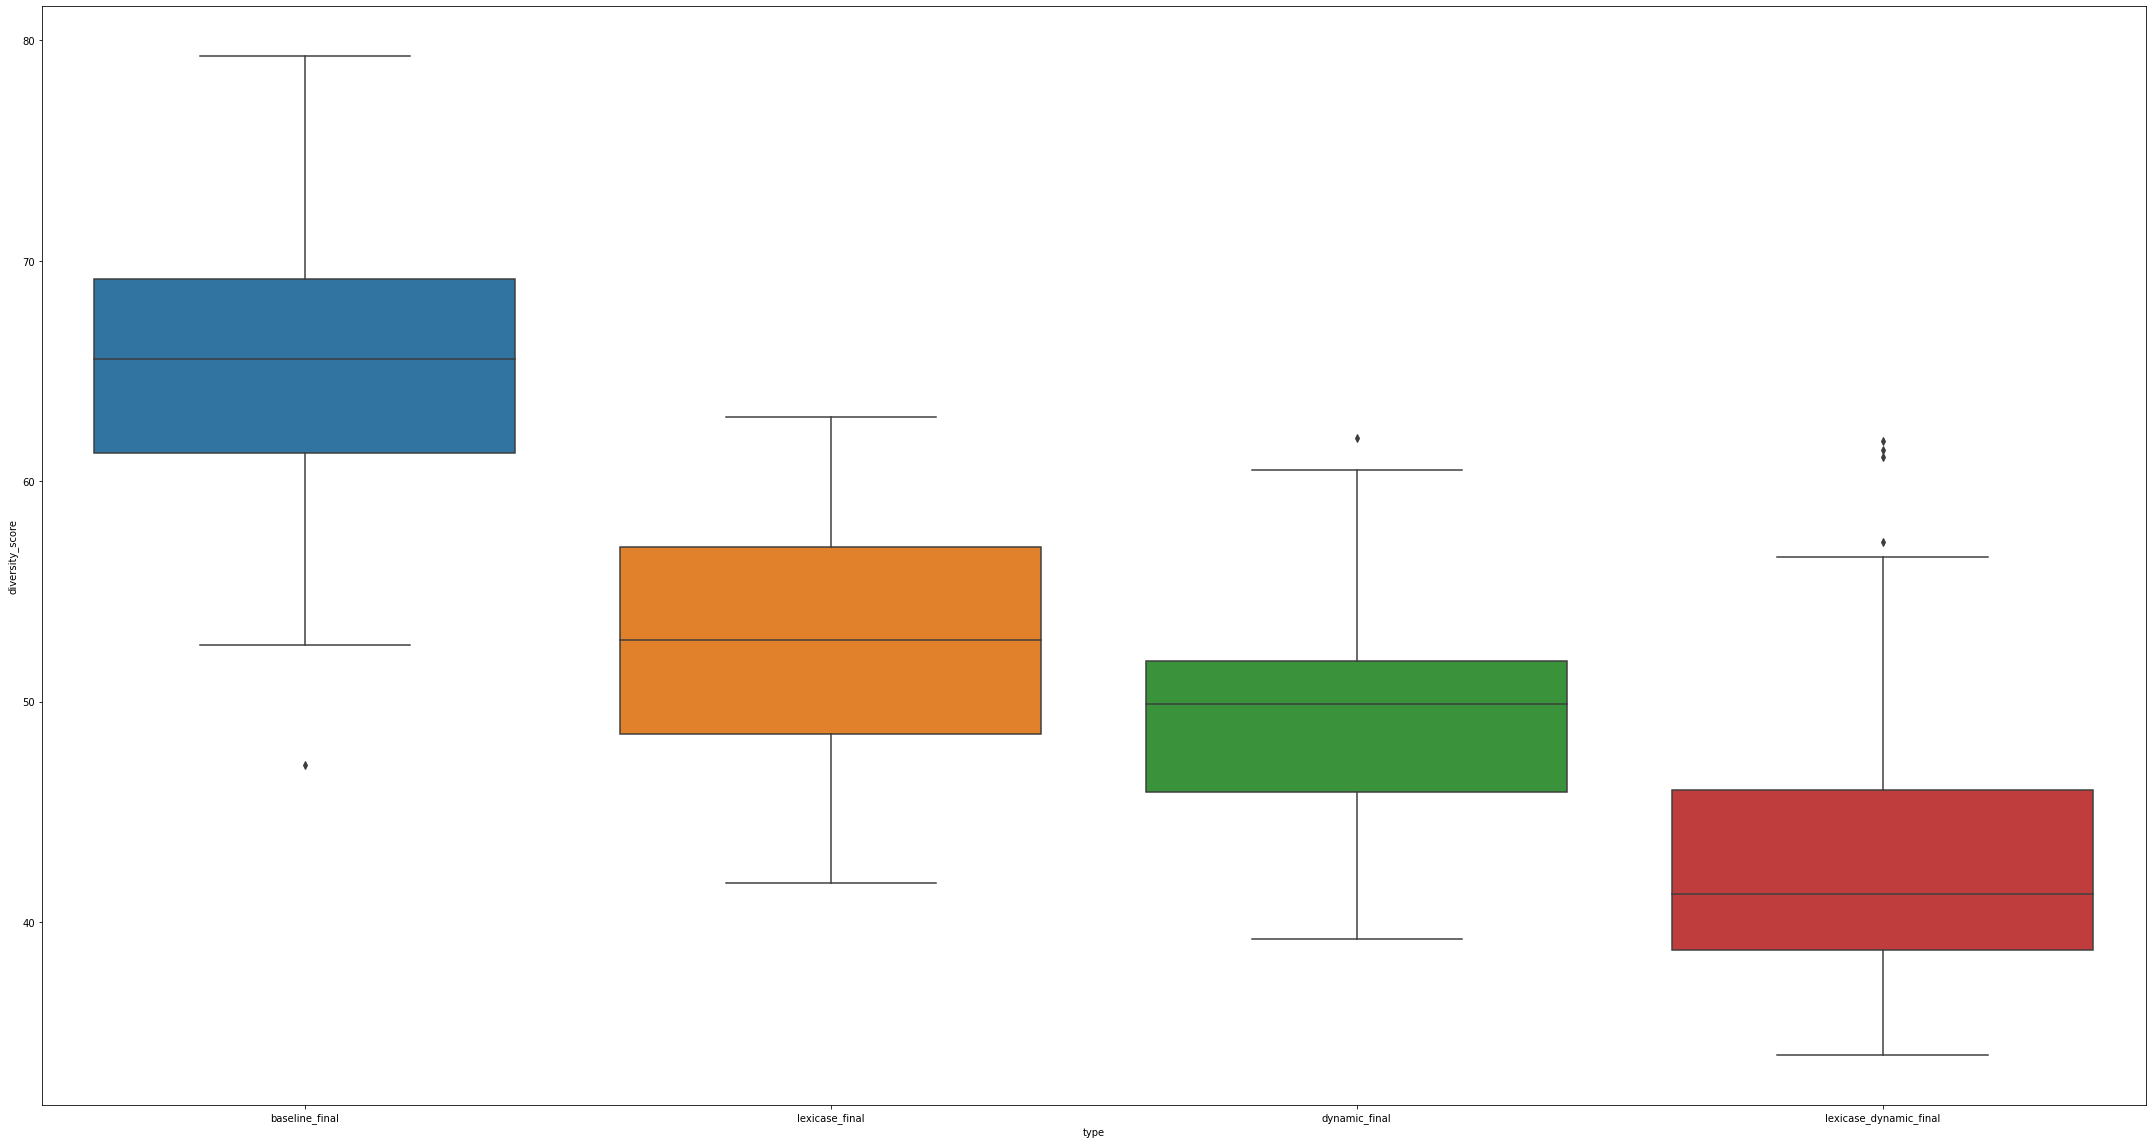

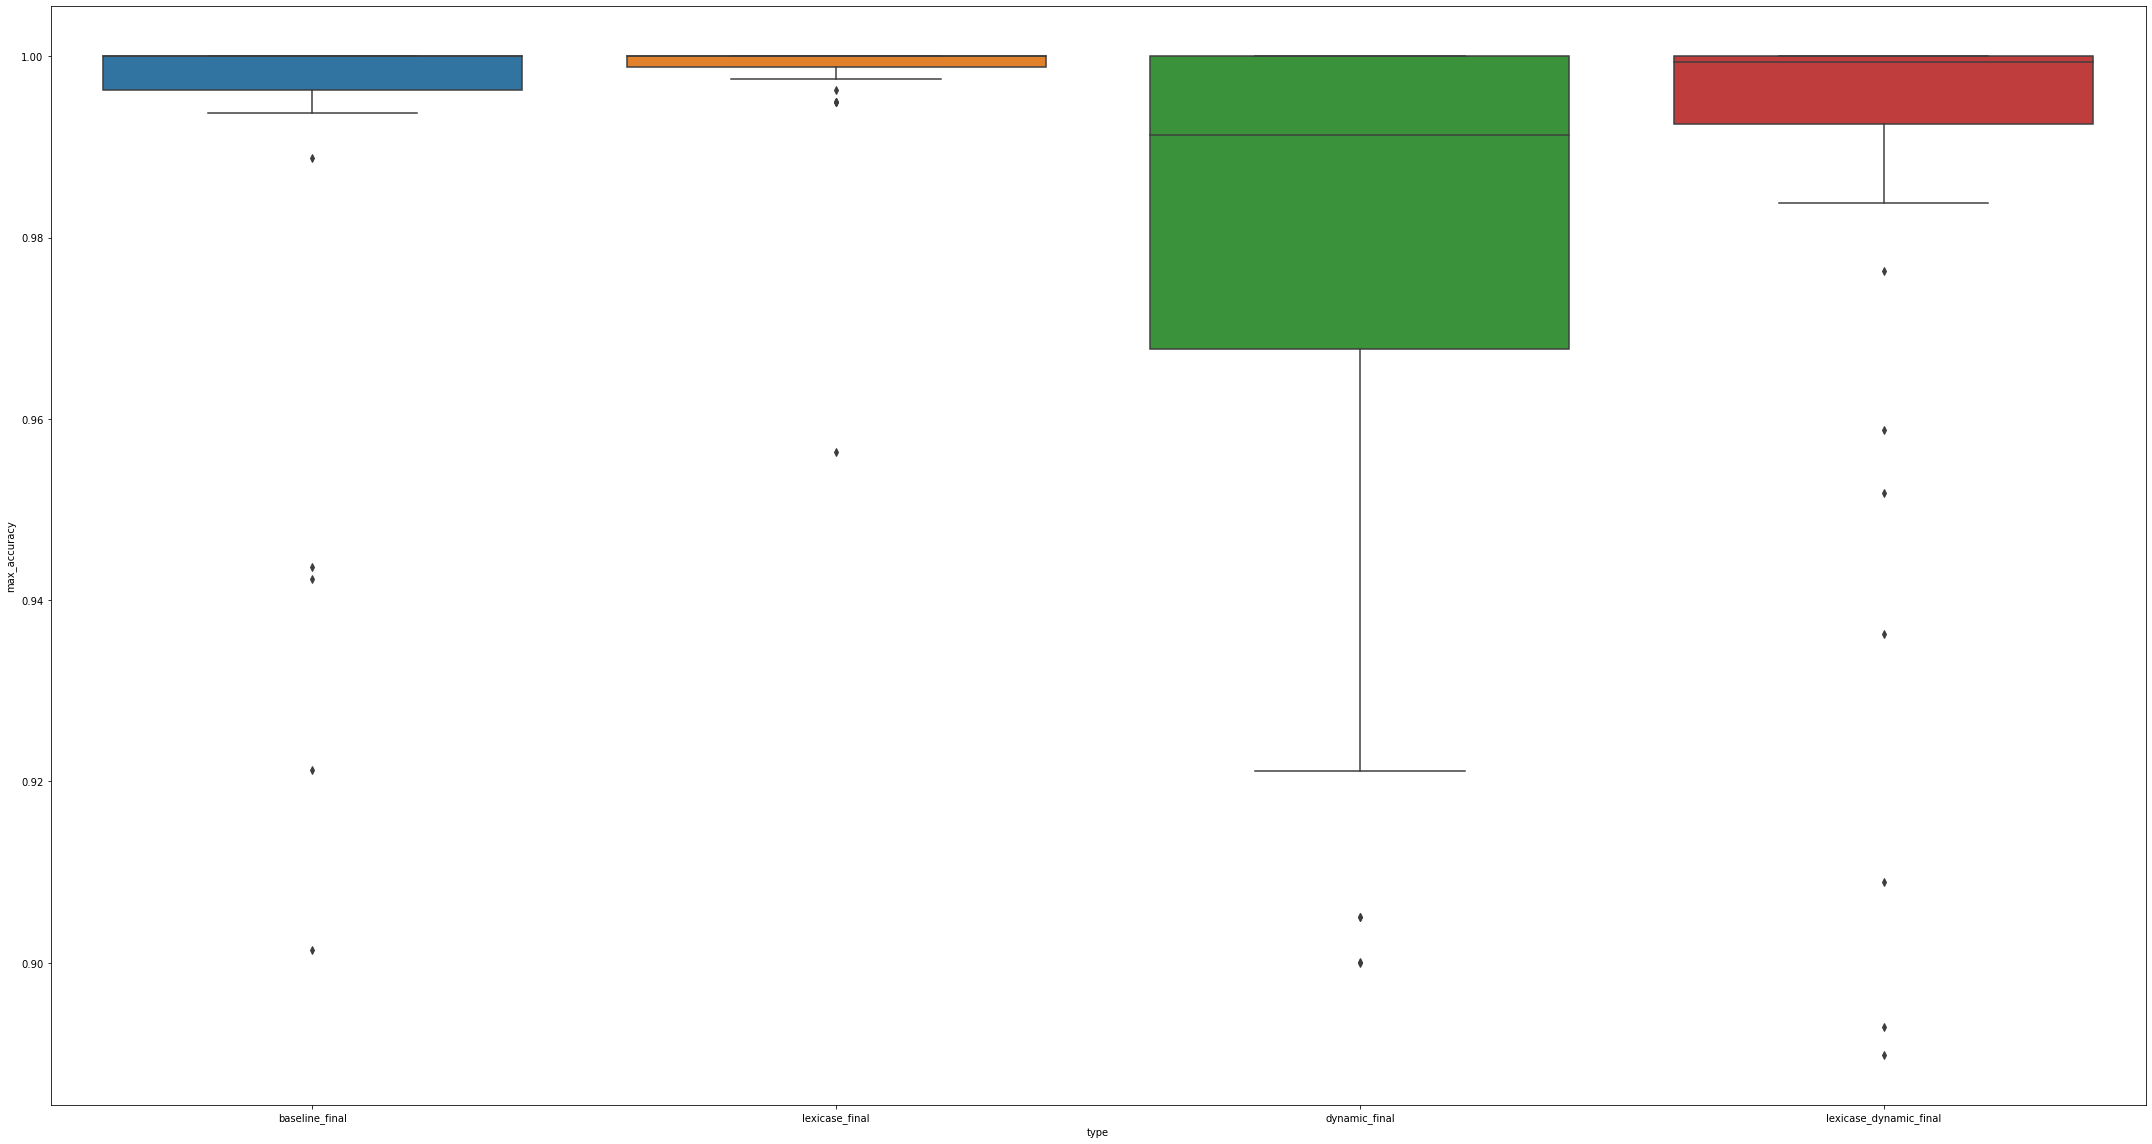

c:\Users\matsumoton\Anaconda3\envs\tpot_env\lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
c:\Users\matsumoton\Anaconda3\envs\tpot_env\lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
c:\Users\matsumoton\Anaconda3\envs\tpot_env\lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
c:\Users\matsumoton\Anaconda3\envs\tpot_env\lib\site-packages\statsmodels\robust\robust_lin

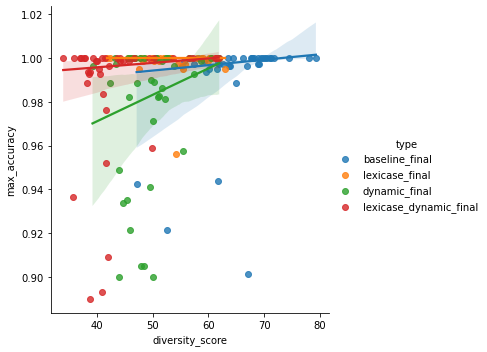

32


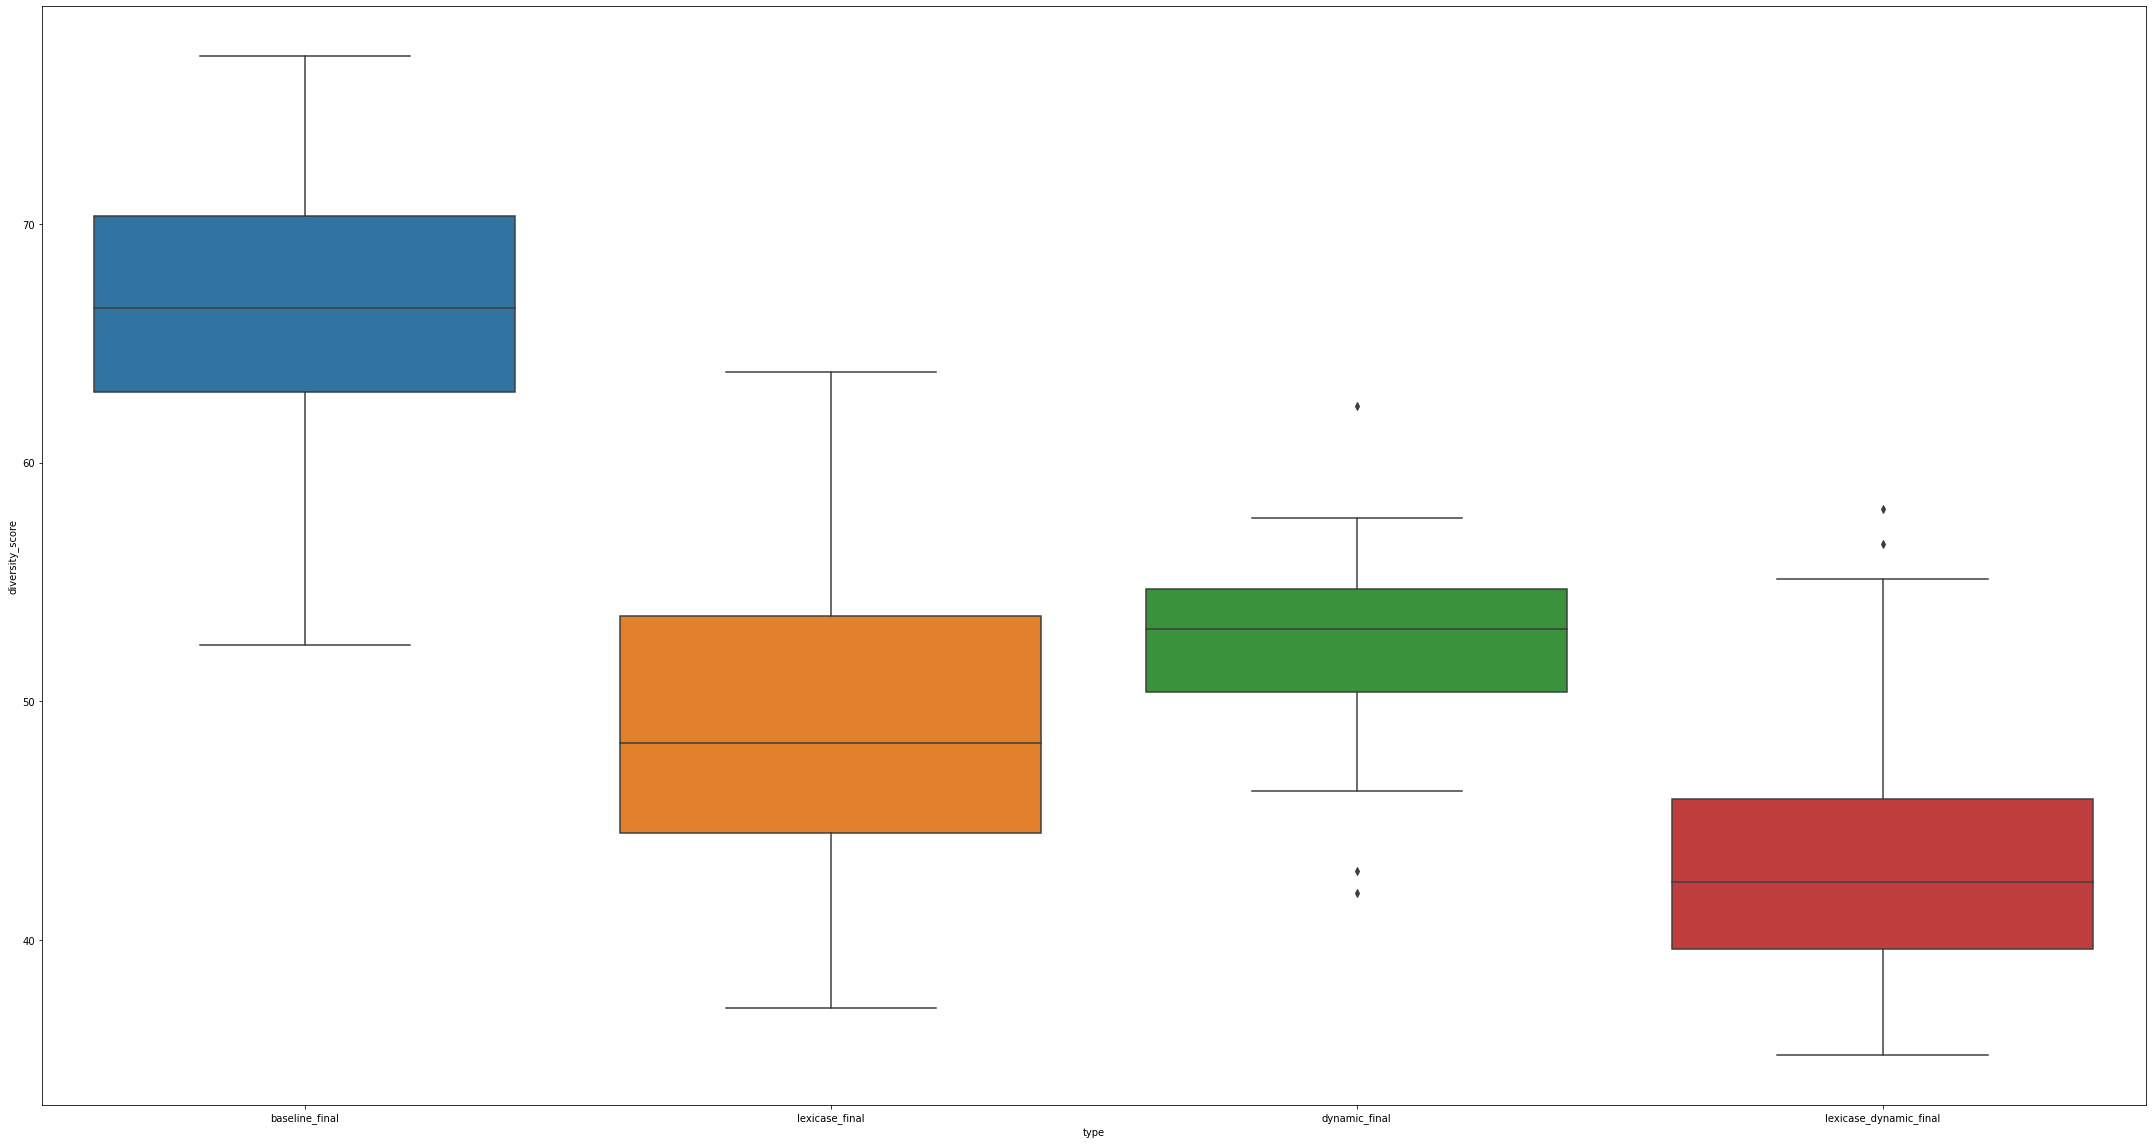

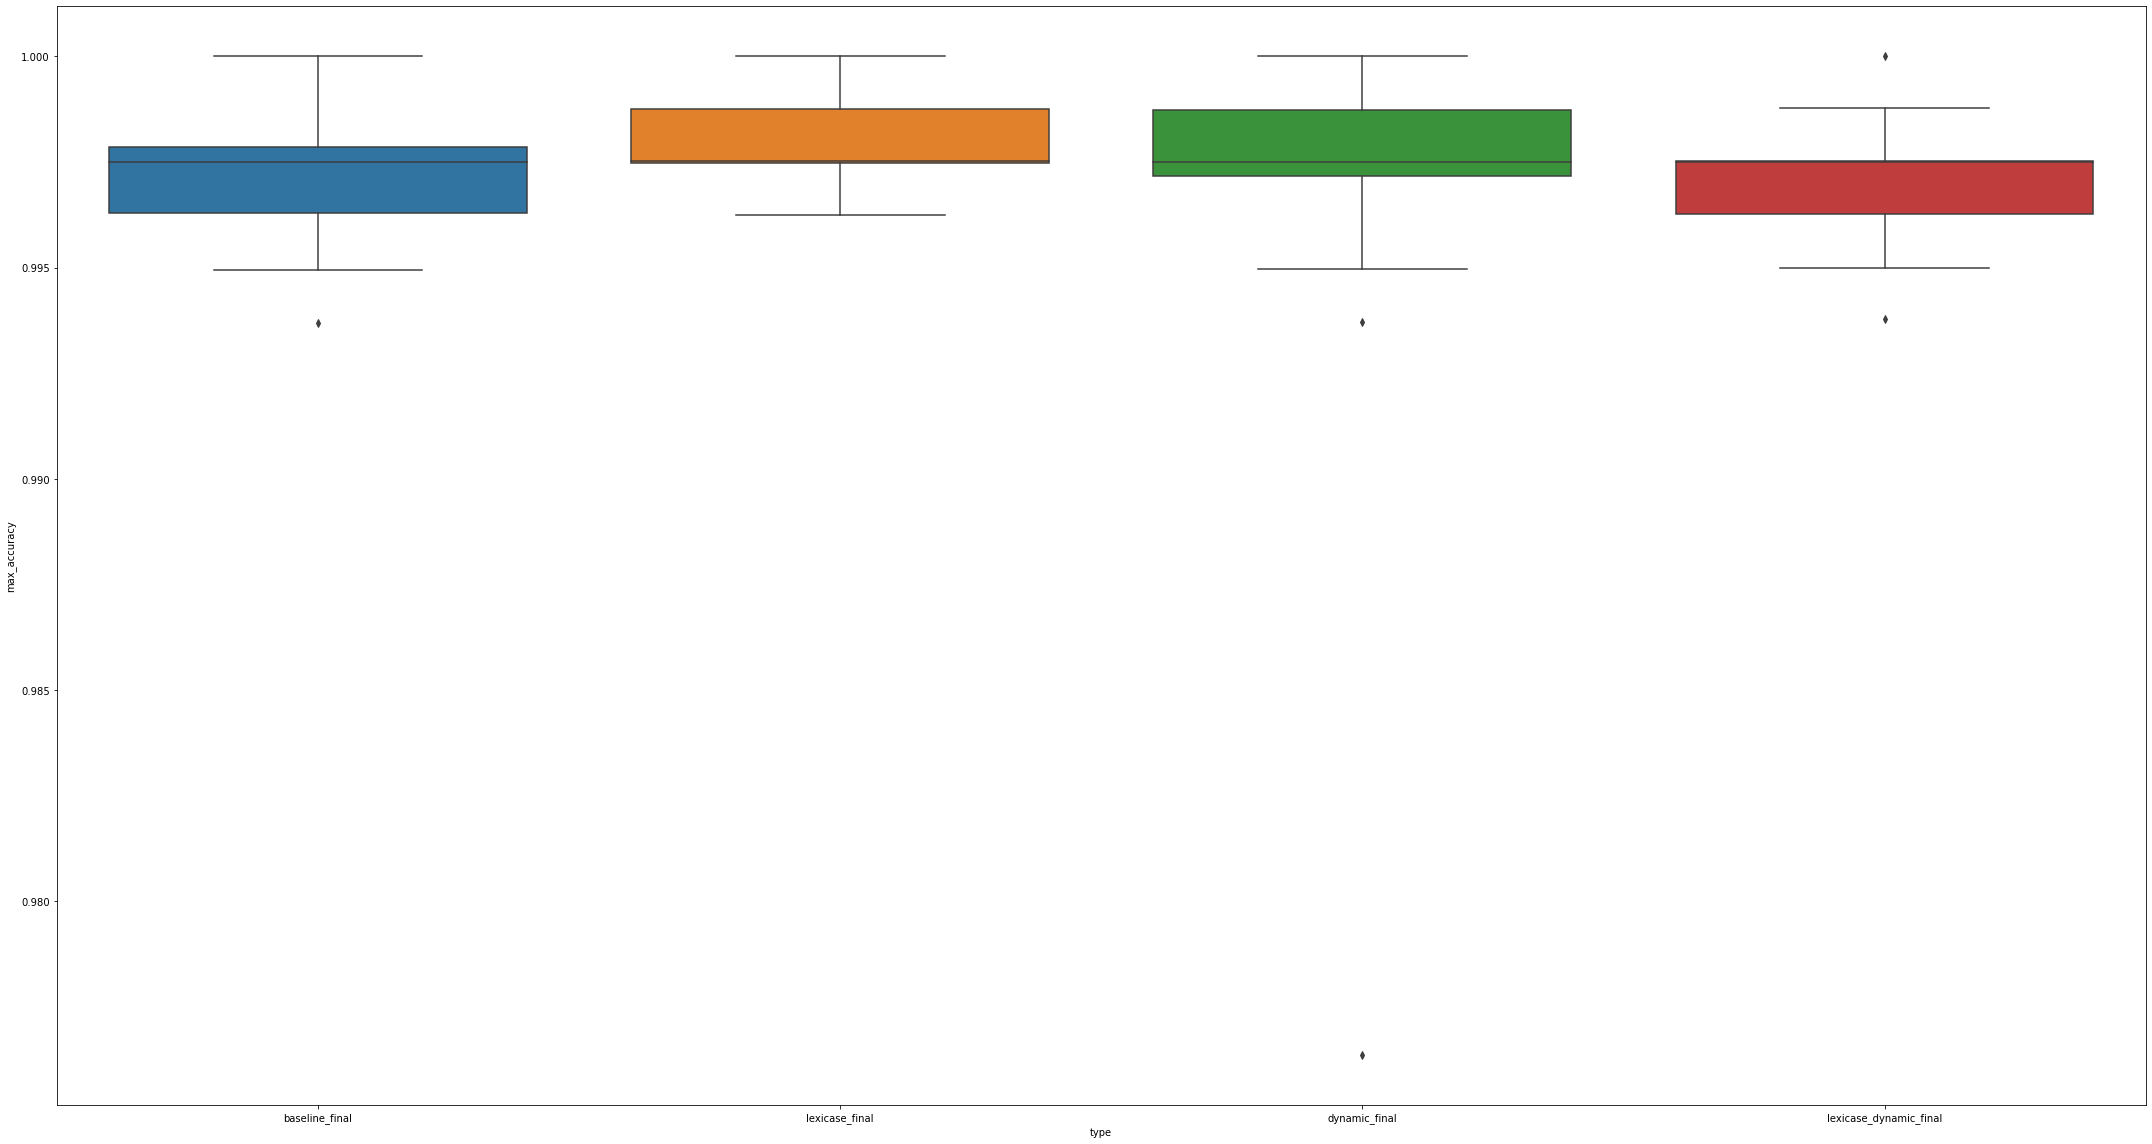

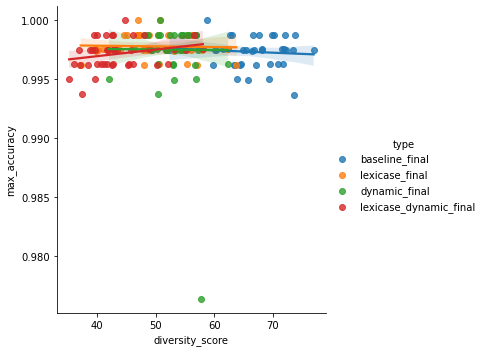

35


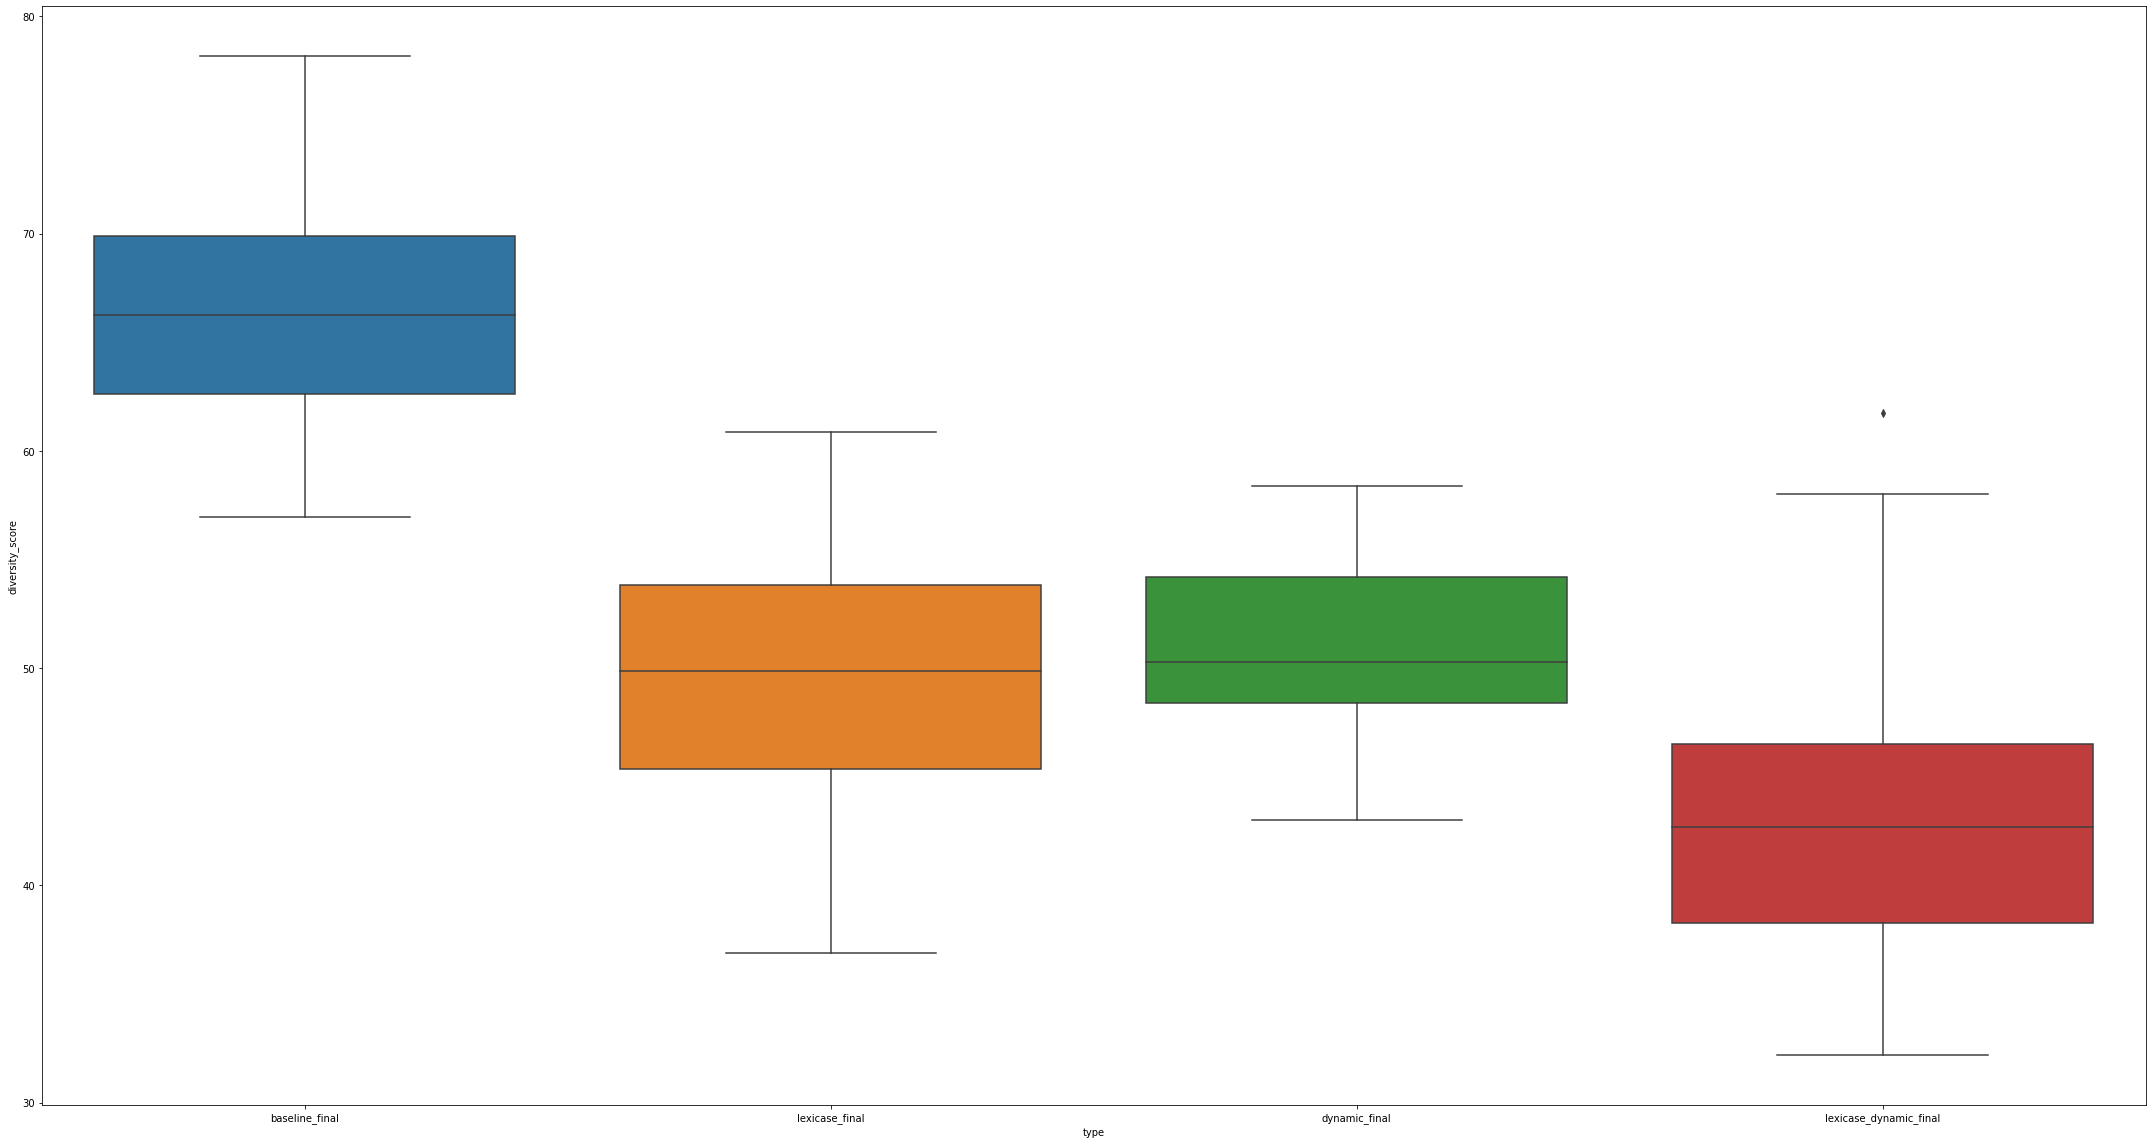

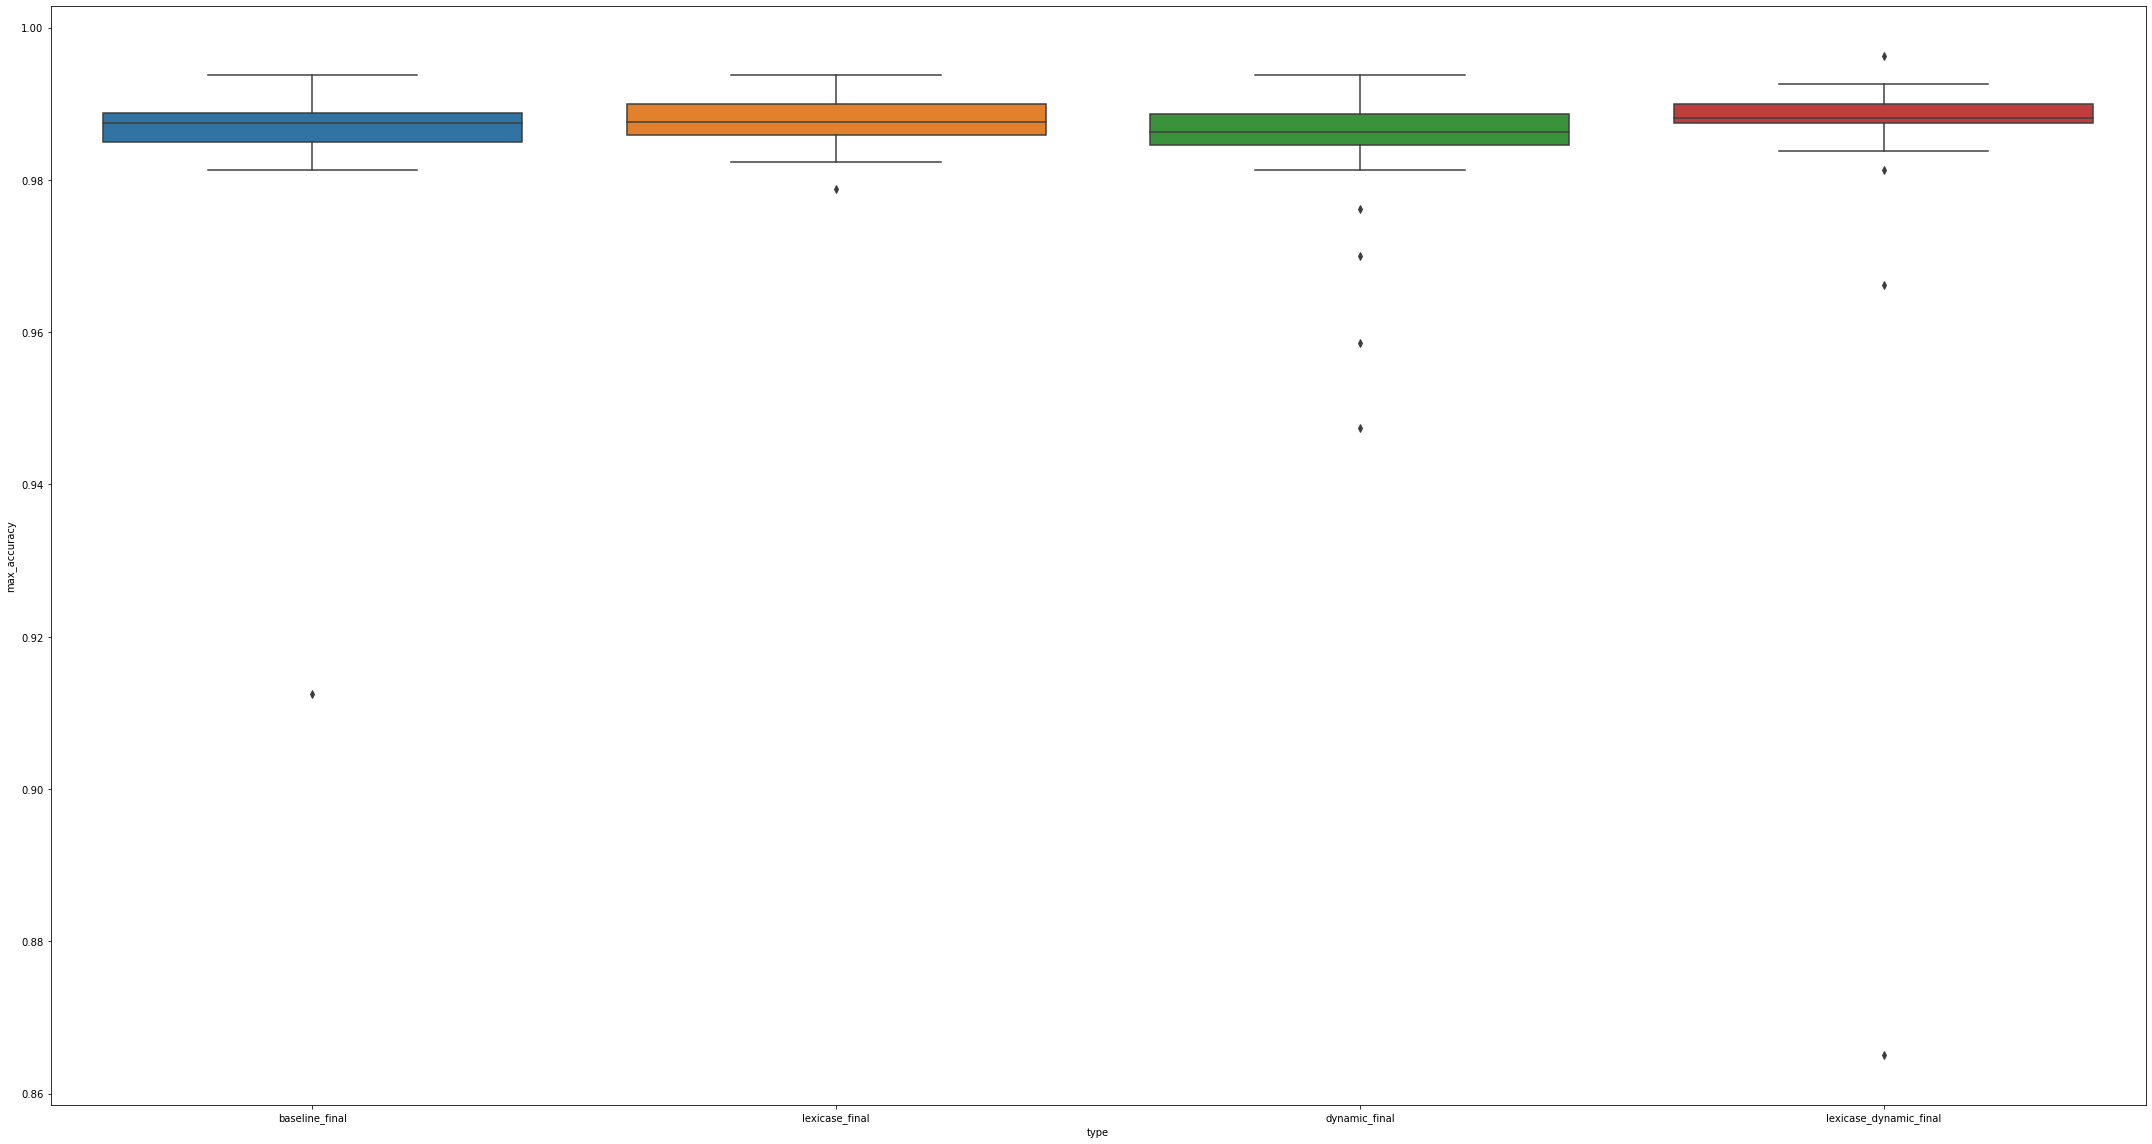

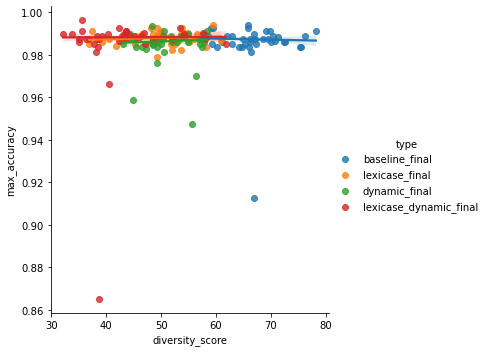

40


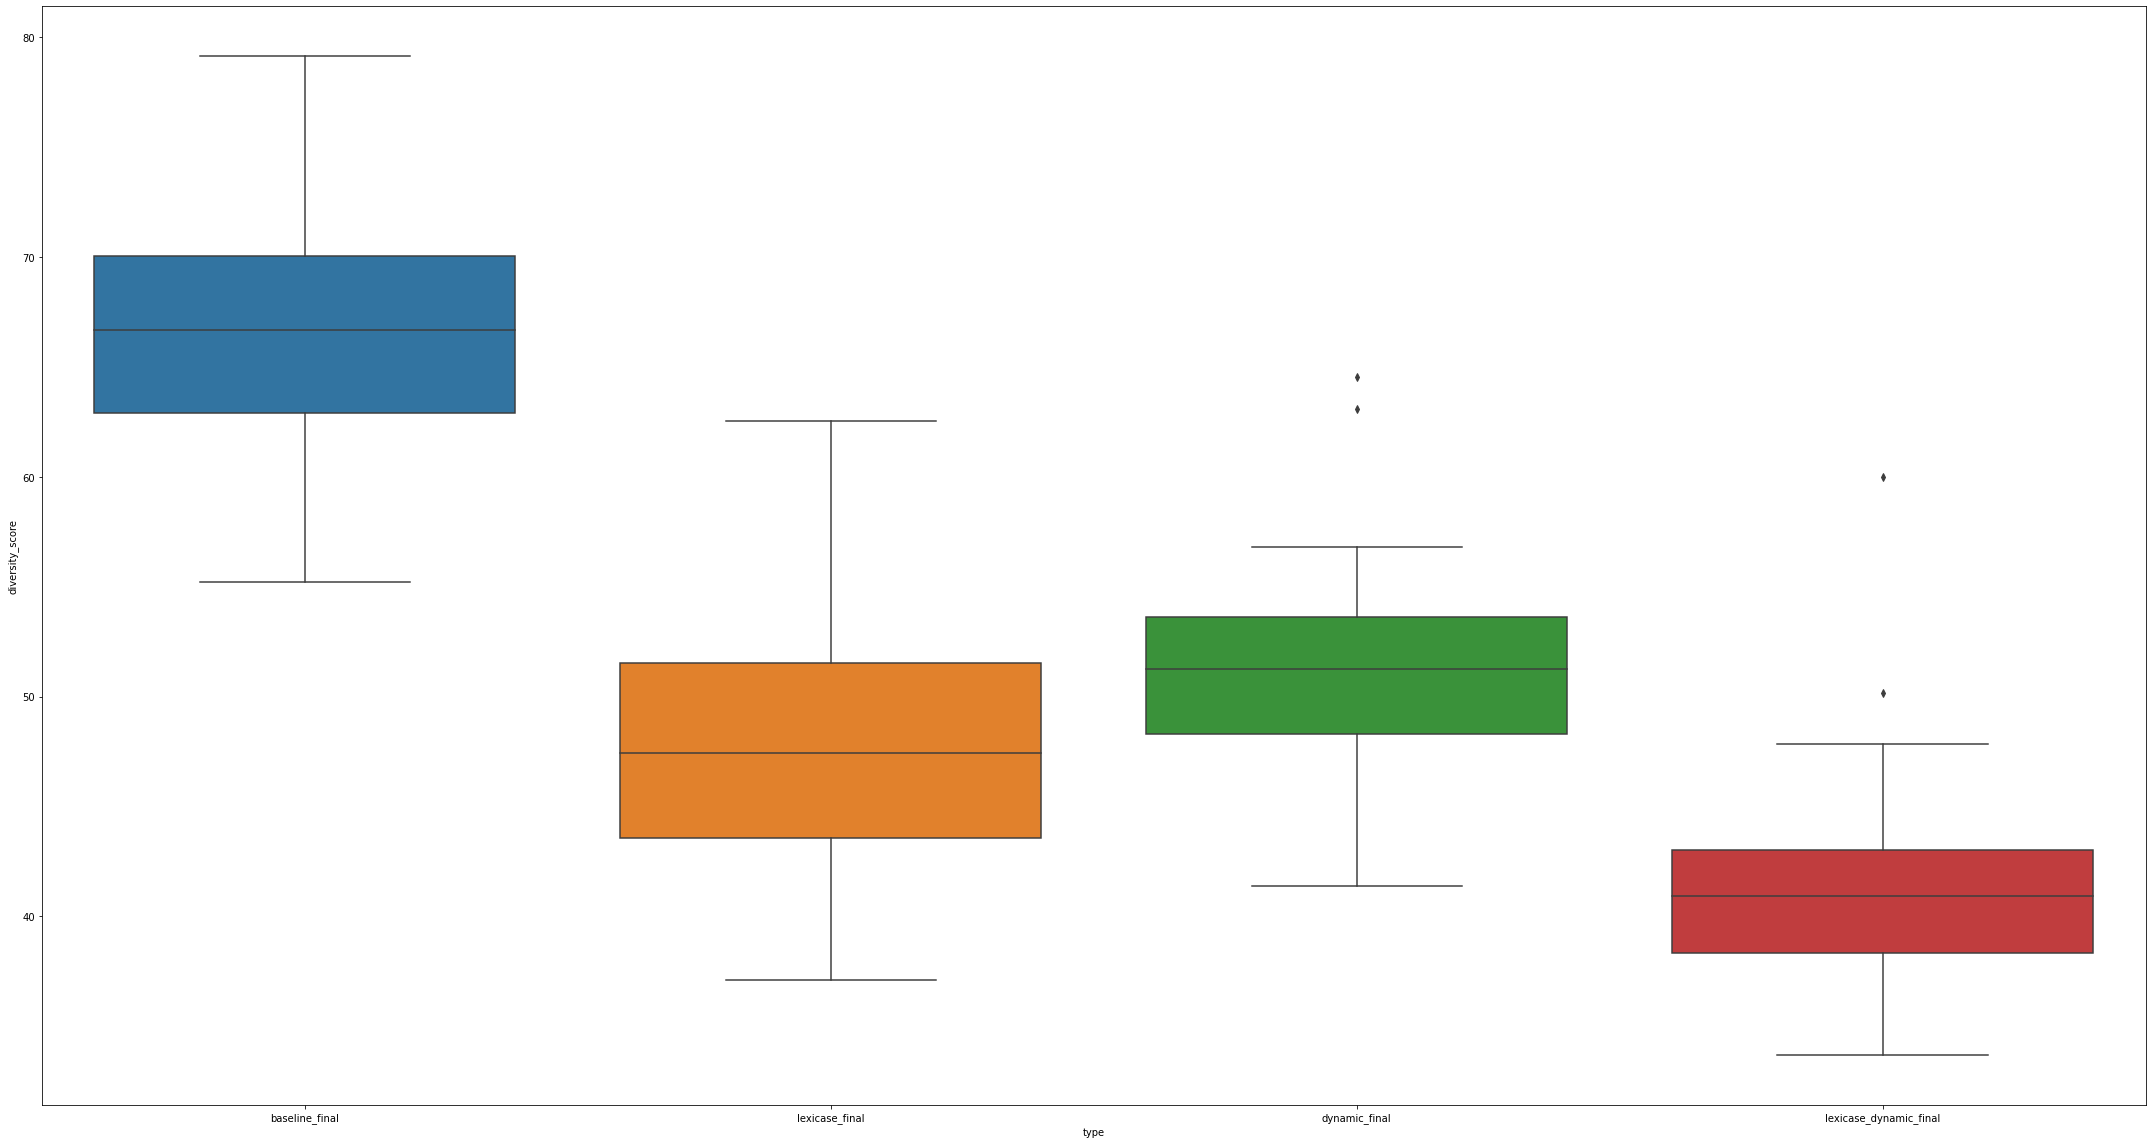

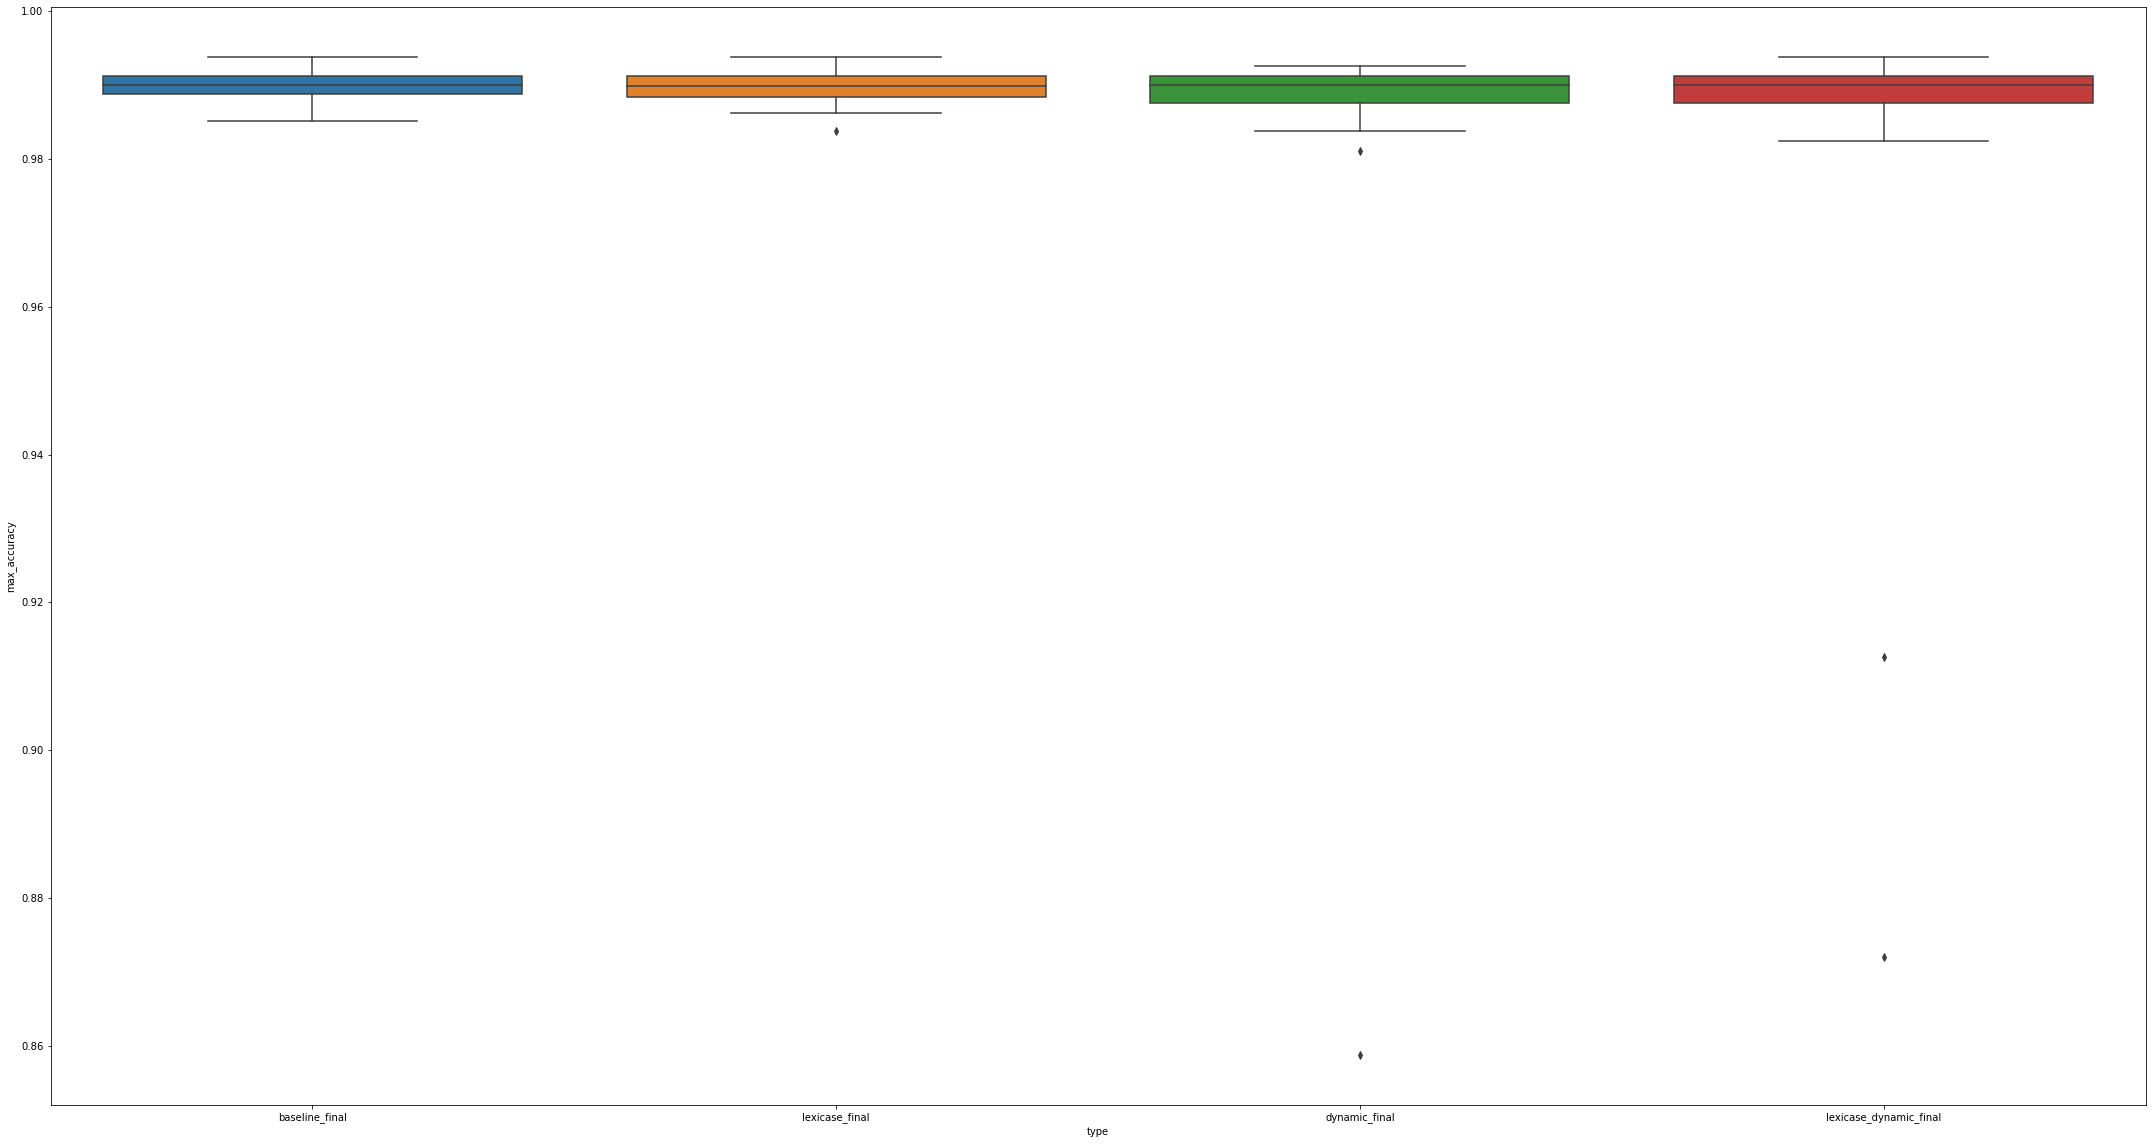

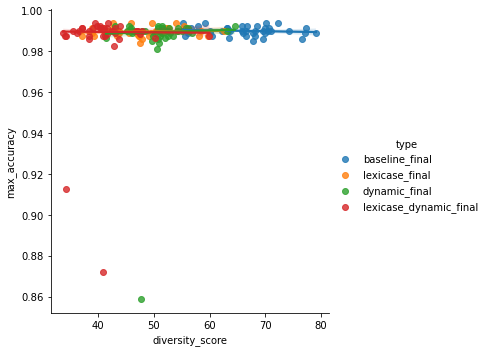

In [8]:
import seaborn
plt.rcParams["figure.figsize"] = (30,16)
for j in [2,4,7,14,23,24,25,27,28,30,32,35,40]:
    print(j)
    ev = []
    for directoryev in directoryevs:
        temp_ev = []
        for i in range(40):
            fitness_df = diversity_scores[j][directoryev][i]
            temp_ev.append(fitness_df)

        temp_ev = pd.DataFrame(temp_ev)
        temp_ev["type"] = directoryev
        ev.append(temp_ev)
    frame_df = pd.concat(ev)
    frame_df = frame_df[~frame_df.isin([np.nan, np.inf, -np.inf]).any(1)]
    frame_df.columns=['diversity_score','max_accuracy','type']
    
    #median normalized
#    for i in range(0,15):
#        median_gen = statistics.median(frame_df.loc[(frame_df['type']=='baseline')&(frame_df['generation']==i)]['score'])
#        frame_df.loc[frame_df['generation']==i,'score']=frame_df.loc[frame_df['generation']==i]['score'].div(median_gen)
    '''
    high_quantile= []
    for i in range(0,15):
        for directoryev in directoryevs:
            upper_quantile = np.quantile(frame_df.loc[frame_df['generation']==i,'score'],0.9)
        
        high_quantile.append(frame_df.loc[(frame_df['generation']==i) & (frame_df['score'] >= upper_quantile)])
    frame_df = pd.concat(high_quantile)
    '''
    #seaborn.violinplot(x="generation",y="score",hue="type",data=frame_df, label = "type" if i == 0 else "")
        
    seaborn.boxplot(x="type",y="diversity_score",data=frame_df)
    
        #ax = sns.swarmplot(x="generation",y="score",hue="type",data=frame_df,color=".25")
    #plt.savefig(f"/Users/matsumoton/Git/meta_pop40_gen15/gen_fitnesses/digen{j}_pop40_gen15.png")
    plt.show()
    seaborn.boxplot(x="type",y="max_accuracy",data=frame_df)
    #seaborn.boxplot(x="type",y="diversity_score",data=frame_df)
    plt.show()
    plt.rcParams["figure.figsize"] = (30,16)
    seaborn.lmplot(x="diversity_score",y="max_accuracy",hue="type",robust=True,data=frame_df)
    plt.show()

In [99]:
import networkx as nx
from pyvis.network import Network
import matplotlib as mpl

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c1='red' #blue
c2='green' #green

graph = pydot.Dot(graph_type='graph') 
stack = [pipeline_trie.root]
parent_stack = []

max_height = 30
while stack:
    s = stack.pop()
    if s.depth >= max_height:
        continue
    for k in s.children.keys():
        stack.append(s.children[k])
        temp =  [v for v in s.total_cv_score if not math.isnan(v) and not math.isinf(v)]
        if len(temp) :
            
            parentnodecolor = colorFader(c1,c2,(sum(temp)/len(temp)-pipeline_trie.root.min_score)/(pipeline_trie.root.max_score-pipeline_trie.root.min_score))
        else:
            parentnodecolor = "#666666"
            
        temp =  [v for v in s.children[k].total_cv_score if not math.isnan(v) and not math.isinf(v)]
        if len(temp) :
          childcolor = colorFader(c1,c2,(sum(temp)/len(temp)-pipeline_trie.root.min_score)/(pipeline_trie.root.max_score-pipeline_trie.root.min_score))
        else:
          childcolor = "#666666"
        
        graph.add_node(pydot.Node(s.path,label=s.primitive,color=parentnodecolor,size=10*(math.tanh(-s.depth+4)+2)))
        graph.add_node(pydot.Node(s.children[k].path,label=s.children[k].primitive,color=childcolor,size=10*(math.tanh(-s.children[k].depth+4)+2)))
        
        edge = pydot.Edge(s.path, s.children[k].path,weight=1,color='#515ba3',value=math.log(s.children[k].traverse_count))
        graph.add_edge(edge)



G = nx.nx_pydot.from_pydot(graph)
nt = Network(height='100%', width='100%', bgcolor='#333333', font_color='white')
nt.from_nx(G)
nt.show('nx.html')

0.8695055371145421

In [67]:
from pyvis.network import Network
g = Network(notebook=True)
nxg = nx.complete_graph(5)
g.from_nx(nxg)
g.show("example.html")